# NBFC Loan Default
*by Garey Salinas*

----

<a id=top></a>
## Contents

- [Overview of Dataset](#overview)
- [Exploratory Data Analysis](#eda)
- [Data Preparation](#processing)
- [Model Building](#modelbuilding)
- [Cross Validation Scores](#cross_validation_scores)
- [XGBoost Classifier](#xgbc)
- [Bagging Classifier](#bagging)
- [Decision Tree Classifier](#dtree)
- [Stacking Classifier](#stacking)
- [Test Set Prediction](#testset)

----


### Background

A non-banking financial institution (NBFI) or non-bank financial company (NBFC) is a Financial Institution that does not have a full banking license or is not supervised by a national or international banking regulatory agency. NBFC facilitates bank-related financial services, such as investment, risk pooling, contractual savings, and market brokering.
The following is the story of a challenge faced by DHDL Ltd. (Name Changed), an NBFC in India. In recent times, the company is struggling to mark profits due to an increase in Loan Defaults. The company aims to determine the relative importance of each parameter with regards to their contribution as to whether a loan is going to default or not. Provided is a sample that contains the data of 90,000 + clients who have taken a loan from the company in the past with the information on whether the loan defaulted. 

----

### Objective

The objective of this exercise is to understand which parameters play an important role in determining whether a client will default on the loan payment.

----

### Data Dictionary

|Labels|Description|
|:-----|:----------|
|ID|unique ID assigned to each applicant|
|loan_amnt|loan amount ($) applied each applicant|
|loan_term|Loan duration in years|
|interest_rate|Applicable interest rate on Loan in %|
|loan_grade|Loan Grade Assigned by the bank|
|loan_subgrade|Loan SubGrade Assigned by the bank|
|job_experience|Number of years job experience| 
|home_ownership|Status of House Ownership|
|annual_income|Annual income of the applicant|
|income_verification_status|Status of Income verification by the bank|
|loan_purpose|Purpose of loan|
|state_code|State code of the applicant's residence|
|debt_to_income|Ratio to total debt to income (total debt might include other loan aswell)|
|delinq_2yrs|number of 30+ days delinquency in past 2 years|
|public_records|number of legal cases against the applicant|
|revolving_balance|total credit revolving balance|
|total_acc|total number of credit lines available in members credit line|
|interest_receive|total interest received by the bank on the loan|
|application_type|Whether the applicant has applied the loan by creating individuall or joint account|
|last_week_pay|How many months have the applicant paid the loan EMI already|
|total_current_balance|total current balance of all the accounts of applicant|
|total_revolving_limit|total revolving credit limit|
|default|status of loan amount, 1 = Defaulter, 0 = Non Defaulters|



----

<a id=overview></a>
## <span style="color:blue">Overview of Dataset</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Import Libraries

In [530]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np   
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)

# to suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
sns.set()

### Load dataset

In [347]:
data = pd.read_csv('Train_set.csv')
df = data.copy()

In [348]:
df.shape

(93174, 23)

In [349]:
pd.concat([df.head(5), df.sample(5), df.tail(5)])

ID  loan_amnt loan_term  interest_rate loan_grade loan_subgrade  \
0      72199369       9000   3 years          9.170          B            B2   
1      14257956      18000   3 years         13.650          C            C1   
2      66216451      16000   3 years          7.260          A            A4   
3      46974169      25000   3 years         13.990          C            C4   
4      46725961      17000   3 years          6.390          A            A2   
15115   1057733       7525   3 years          7.620          A            A3   
26036  32098024      22100   3 years         12.490          B            B5   
26870  16530444      23500   5 years         25.830          G            G2   
14118  71256813      20000   5 years          9.760          B            B3   
45991  11988441      33950   3 years         18.250          D            D3   
93169  65577252       3200   3 years          7.260          A            A4   
93170    836021       3500   3 years          5.420          A            A1   
93171  33058720       8000   3 years         13.980          C            C3   
93172   4060472      35000   3 years         17.770          D            D1   
93173   3628127      10000   3 years         15.800          C            C3   

      job_experience home_ownership  annual_income income_verification_status  \
0           <5 Years            OWN      85000.000               Not Verified   
1           <5 Years            OWN      64000.000                   Verified   
2           <5 Years       MORTGAGE     150000.000            Source Verified   
3                NaN       MORTGAGE      59800.000                   Verified   
4          10+ years       MORTGAGE      72000.000            Source Verified   
15115       <5 Years           RENT     165000.000               Not Verified   
26036      10+ years       MORTGAGE      48240.000            Source Verified   
26870      10+ years       MORTGAGE      70000.000            Source Verified   
14118       <5 Years       MORTGAGE     100000.000               Not Verified   
45991      10+ years       MORTGAGE      74000.000                   Verified   
93169       <5 Years           RENT      85000.000               Not Verified   
93170            NaN       MORTGAGE      57550.000               Not Verified   
93171      10+ years           RENT     148531.500            Source Verified   
93172       <5 Years           RENT     100000.000                   Verified   
93173       <5 Years           RENT      60000.000                   Verified   

       ... delinq_2yrs public_records  revolving_balance  total_acc  \
0      ...       0.000          0.000              39519     20.000   
1      ...       0.000          1.000               9783     24.000   
2      ...       2.000          0.000              13641     27.000   
3      ...       0.000          0.000              35020     35.000   
4      ...       0.000          0.000              23990     26.000   
15115  ...       0.000          0.000              55342     25.000   
26036  ...       0.000          0.000              11381     41.000   
26870  ...       0.000          2.000              17006     19.000   
14118  ...       0.000          0.000              24672     50.000   
45991  ...       0.000          1.000                754     36.000   
93169  ...       0.000          0.000               7924     38.000   
93170  ...       0.000          0.000              10174     24.000   
93171  ...       1.000          0.000               5391     25.000   
93172  ...       0.000          0.000              24609     45.000   
93173  ...       0.000          0.000              11285      7.000   

       interest_receive  application_type  last_week_pay  \
0                59.600        INDIVIDUAL          4.000   
1              3348.250        INDIVIDUAL         95.000   
2               276.690        INDIVIDUAL         13.000   
3              1106.720        INDIVIDUAL         17.000  

In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93174 entries, 0 to 93173
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          93174 non-null  int64  
 1   loan_amnt                   93174 non-null  int64  
 2   loan_term                   93174 non-null  object 
 3   interest_rate               93174 non-null  float64
 4   loan_grade                  93174 non-null  object 
 5   loan_subgrade               93174 non-null  object 
 6   job_experience              88472 non-null  object 
 7   home_ownership              93174 non-null  object 
 8   annual_income               93173 non-null  float64
 9   income_verification_status  93174 non-null  object 
 10  loan_purpose                93174 non-null  object 
 11  state_code                  93174 non-null  object 
 12  debt_to_income              93174 non-null  float64
 13  delinq_2yrs                 931

In [351]:
display(df.describe(include='all').T)
display(df.describe(include='float').T)
df.describe(include='object').T

count unique                 top   freq  \
ID                         93174.000    NaN                 NaN    NaN   
loan_amnt                  93174.000    NaN                 NaN    NaN   
loan_term                      93174      2             3 years  65211   
interest_rate              93174.000    NaN                 NaN    NaN   
loan_grade                     93174      7                   B  26865   
loan_subgrade                  93174     35                  B4   5879   
job_experience                 88472      3            <5 Years  40610   
home_ownership                 93174      5            MORTGAGE  46445   
annual_income              93173.000    NaN                 NaN    NaN   
income_verification_status     93174      3     Source Verified  34487   
loan_purpose                   93174      4  debt_consolidation  55241   
state_code                     93174     50                  CA  13744   
debt_to_income             93174.000    NaN                 NaN    NaN   
delinq_2yrs                93172.000    NaN                 NaN    NaN   
public_records             93172.000    NaN                 NaN    NaN   
revolving_balance          93174.000    NaN                 NaN    NaN   
total_acc                  93172.000    NaN                 NaN    NaN   
interest_receive           93174.000    NaN                 NaN    NaN   
application_type               93174      2          INDIVIDUAL  93118   
last_week_pay              91250.000    NaN                 NaN    NaN   
total_current_balance      85788.000    NaN                 NaN    NaN   
total_revolving_limit      85788.000    NaN                 NaN    NaN   
default                    93174.000    NaN                 NaN    NaN   

                                   mean          std       min          25%  \
ID                         35050211.389 24149262.074 70735.000 10859832.500   
loan_amnt                     14733.861     8428.185   500.000     8000.000   
loan_term                           NaN          NaN       NaN          NaN   
interest_rate                    13.233        4.369     5.320        9.990   
loan_grade                          NaN          NaN       NaN          NaN   
loan_subgrade                       NaN          NaN       NaN          NaN   
job_experience                      NaN          NaN       NaN          NaN   
home_ownership                      NaN          NaN       NaN          NaN   
annual_income                 75028.259    69454.784  1200.000    45000.000   
income_verification_status          NaN          NaN       NaN          NaN   
loan_purpose                        NaN          NaN       NaN          NaN   
state_code                          NaN          NaN       NaN          NaN   
debt_to_income                   18.128        8.563     0.000       11.930   
delinq_2yrs                       0.317        0.881     0.000        0.000   
public_records                    0.196        0.581     0.000        0.000   
revolving_balance             16854.469    23689.074     0.000     6433.000   
total_acc                        25.249       11.855     1.000       17.000   
interest_receive               1747.264     2088.236     0.000      439.880   
application_type                    NaN          NaN       NaN          NaN   
last_week_pay                    58.155       44.327     0.000       22.000   
total_current_balance        139252.923   157686.791     0.000    29642.000   
total_revolving_limit         32085.903    47052.515     0.000    14000.000   
default                           0.238        0.426     0.000        0.000   

                                    50%          75%          max  
ID                         37107507.000 58598949.500 73519746.000  
loan_amnt                     13000.000    20000.000    35000.000  
loan_term                           NaN          NaN          NaN  
interest_rate                    12.990       16.200       28.990  
loan_grade       

count       mean        std      min       25%  \
interest_rate         93174.000     13.233      4.369    5.320     9.990   
annual_income         93173.000  75028.259  69454.784 1200.000 45000.000   
debt_to_income        93174.000     18.128      8.563    0.000    11.930   
delinq_2yrs           93172.000      0.317      0.881    0.000     0.000   
public_records        93172.000      0.196      0.581    0.000     0.000   
total_acc             93172.000     25.249     11.855    1.000    17.000   
interest_receive      93174.000   1747.264   2088.236    0.000   439.880   
last_week_pay         91250.000     58.155     44.327    0.000    22.000   
total_current_balance 85788.000 139252.923 157686.791    0.000 29642.000   
total_revolving_limit 85788.000  32085.903  47052.515    0.000 14000.000   

                            50%        75%         max  
interest_rate            12.990     16.200      28.990  
annual_income         64000.000  90000.000 9500000.000  
debt_to_income           17.640     23.890     672.520  
delinq_2yrs               0.000      0.000      22.000  
public_records            0.000      0.000      49.000  
total_acc                24.000     32.000     119.000  
interest_receive       1070.755   2219.613   23172.310  
last_week_pay            48.000     83.000     291.000  
total_current_balance 79363.500 207160.000 8000078.000  
total_revolving_limit 23700.000  39700.000 9999999.000

count unique                 top   freq
loan_term                   93174      2             3 years  65211
loan_grade                  93174      7                   B  26865
loan_subgrade               93174     35                  B4   5879
job_experience              88472      3            <5 Years  40610
home_ownership              93174      5            MORTGAGE  46445
income_verification_status  93174      3     Source Verified  34487
loan_purpose                93174      4  debt_consolidation  55241
state_code                  93174     50                  CA  13744
application_type            93174      2          INDIVIDUAL  93118

In [352]:
try:
    df.drop(['ID'], axis=1, inplace=True)
except:
    print("ID column already dropped")
df.columns

Index(['loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'default'],
      dtype='object')

In [353]:
df.isnull().sum().sort_values(ascending=False)

total_revolving_limit         7386
total_current_balance         7386
job_experience                4702
last_week_pay                 1924
delinq_2yrs                      2
total_acc                        2
public_records                   2
annual_income                    1
loan_amnt                        0
application_type                 0
interest_receive                 0
revolving_balance                0
debt_to_income                   0
loan_term                        0
state_code                       0
loan_purpose                     0
income_verification_status       0
home_ownership                   0
loan_subgrade                    0
loan_grade                       0
interest_rate                    0
default                          0
dtype: int64

In [354]:
df.isnull().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                4702
home_ownership                   0
annual_income                    1
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      2
public_records                   2
revolving_balance                0
total_acc                        2
interest_receive                 0
application_type                 0
last_week_pay                 1924
total_current_balance         7386
total_revolving_limit         7386
default                          0
dtype: int64

In [355]:
df.duplicated().sum()

0

In [356]:
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].astype('category')
df.select_dtypes(include='category').columns

Index(['loan_term', 'loan_grade', 'loan_subgrade', 'job_experience',
       'home_ownership', 'income_verification_status', 'loan_purpose',
       'state_code', 'application_type'],
      dtype='object')

In [357]:
for i in df.select_dtypes(include=['category']).columns:
    print('Unique values in', i, 'are :')
    print(df[i].value_counts(dropna=False))
    print('*'*50)

Unique values in loan_term are :
3 years    65211
5 years    27963
Name: loan_term, dtype: int64
**************************************************
Unique values in loan_grade are :
B    26865
C    25787
A    15534
D    14715
E     7378
F     2344
G      551
Name: loan_grade, dtype: int64
**************************************************
Unique values in loan_subgrade are :
B4    5879
B3    5879
C2    5479
C1    5443
C3    5270
C4    5182
B2    5169
B5    5095
B1    4843
A5    4723
C5    4413
D1    3716
A4    3631
D2    3239
D3    2759
D4    2717
A3    2450
A1    2377
A2    2353
D5    2284
E1    1924
E2    1736
E3    1513
E4    1228
E5     977
F1     745
F2     545
F3     465
F4     355
F5     234
G1     174
G2     146
G3     105
G5      66
G4      60
Name: loan_subgrade, dtype: int64
**************************************************
Unique values in job_experience are :
<5 Years      40610
10+ years     30362
6-10 years    17500
NaN            4702
Name: job_experience, dtype: int64

<a id=eda></a>
## <span style="color:blue">Exploratory Data Analysis</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Univariate Analysis

In [358]:
def histogram_boxplot(feature, figsize=(15, 7), bins=None):
    """ 
    Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (15,10))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=True, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='blue', linestyle='-');# Add median to the histogram

In [359]:
def perc_on_bar(feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    #Creating a countplot for the feature
    sns.set(rc={'figure.figsize':(15,7)})
    ax=sns.countplot(x=feature, data=data, palette='mako')
    
    total = len(feature) # length of the column
    for p in ax.patches:
        # percentage of each class of the category
        percentage = 100 * p.get_height()/total
        percentage_label = f"{percentage:.1f}%"
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage_label, (x, y), size = 12) # annotate the percantage
        
    plt.show() # show the plot

In [360]:
### Function to plot distributions and Boxplots of customers
def target_plot(x, target='default'):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    fig,axs = plt.subplots(2, 2, figsize=(12,10))
    axs[0, 0].set_title('Distribution of an default')
    sns.distplot(data[(data[target] == 1)][x], ax=axs[0,0], color='teal')
    axs[0, 1].set_title('Distribution of an non-default')
    sns.distplot(data[(data[target] == 0)][x], ax=axs[0,1], color='orange')
    
    axs[1,0].set_title('Boxplot w.r.t default')
    sns.boxplot(data[target],data[x], ax=axs[1,0],palette='gist_rainbow')
    axs[1,1].set_title('Boxplot w.r.t non-default - Without outliers')
    sns.boxplot(data[target],data[x],ax=axs[1,1],showfliers=False,palette='gist_rainbow')
    plt.tight_layout()
    plt.show()

In [361]:
df.select_dtypes(include='integer').columns

Index(['loan_amnt', 'revolving_balance', 'default'], dtype='object')

### loan_amnt

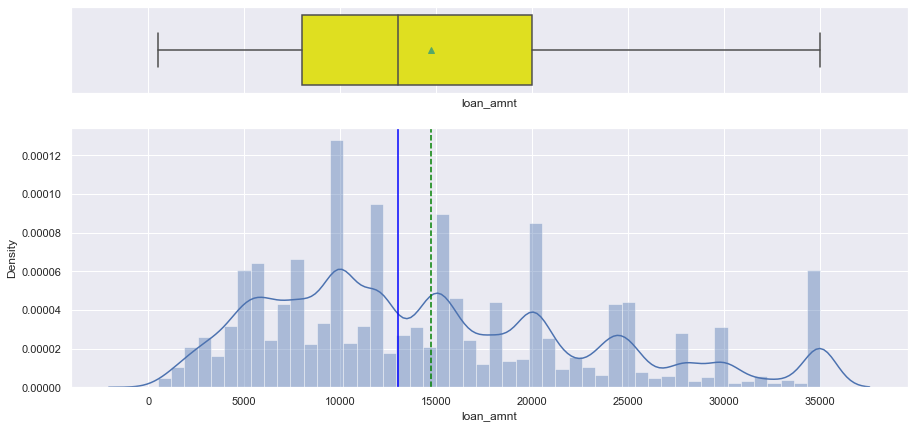

In [362]:
histogram_boxplot(df.loan_amnt)

### revolving_balance

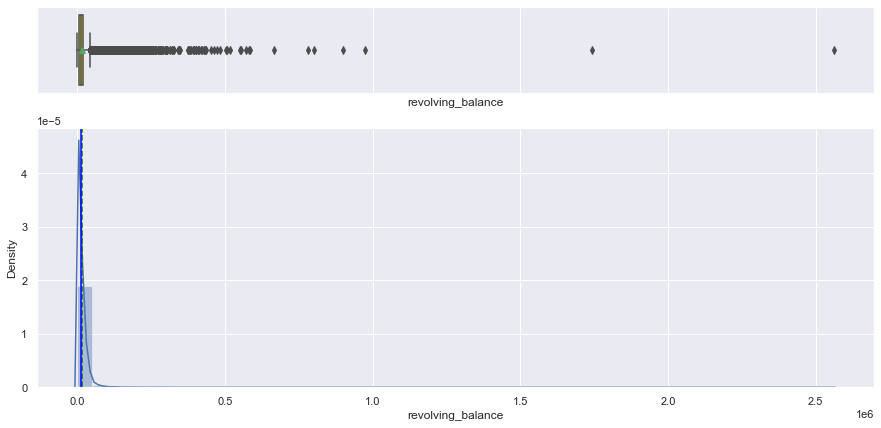

In [363]:
histogram_boxplot(df.revolving_balance)

### default

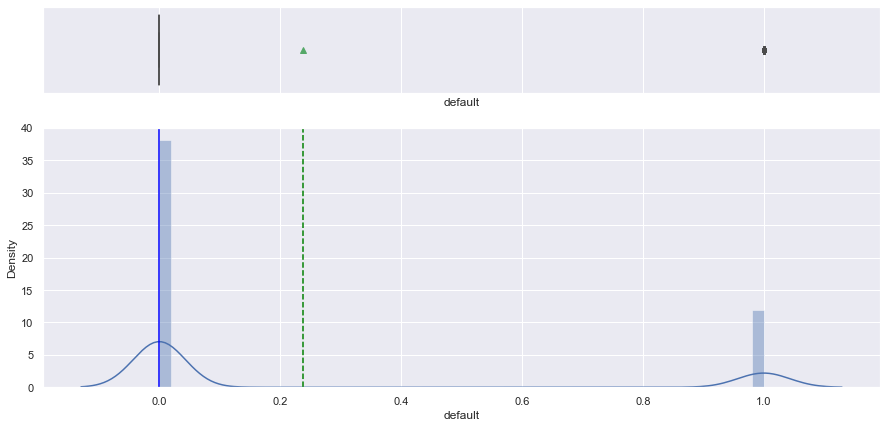

In [364]:
histogram_boxplot(df.default)

In [365]:
df.select_dtypes(include='float').columns

Index(['interest_rate', 'annual_income', 'debt_to_income', 'delinq_2yrs',
       'public_records', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit'],
      dtype='object')

### interest_rate

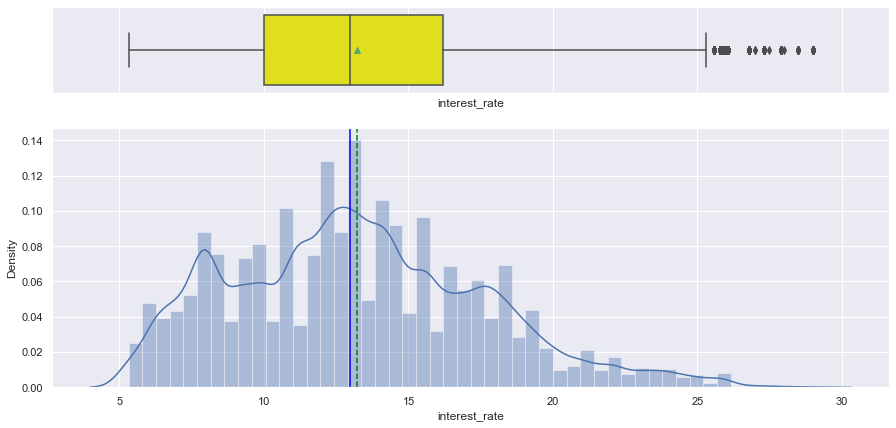

In [366]:
histogram_boxplot(df.interest_rate)

### annual_income

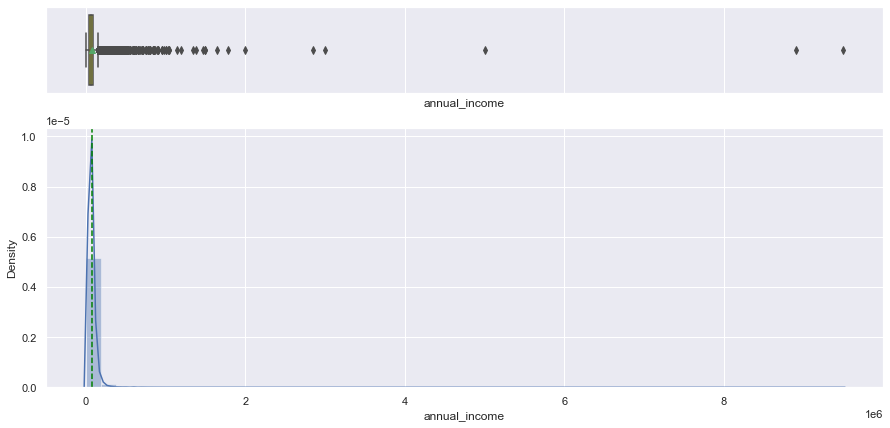

In [367]:
histogram_boxplot(df.annual_income)

### debt_to_income

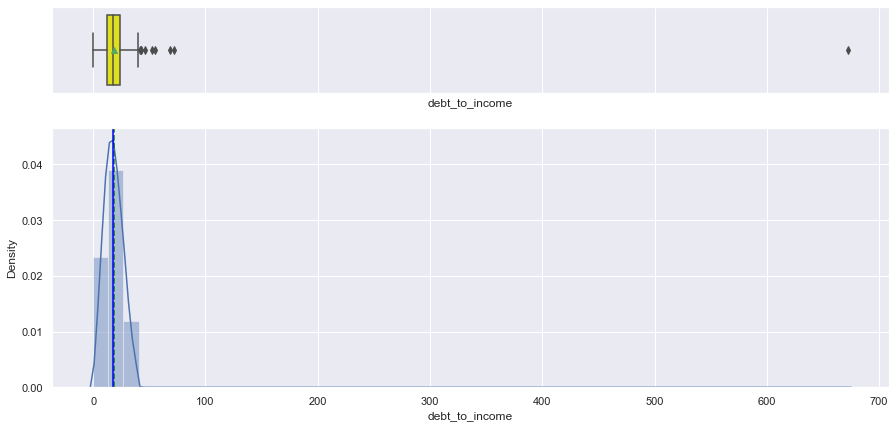

In [368]:
histogram_boxplot(df.debt_to_income)

### delinq_2yrs

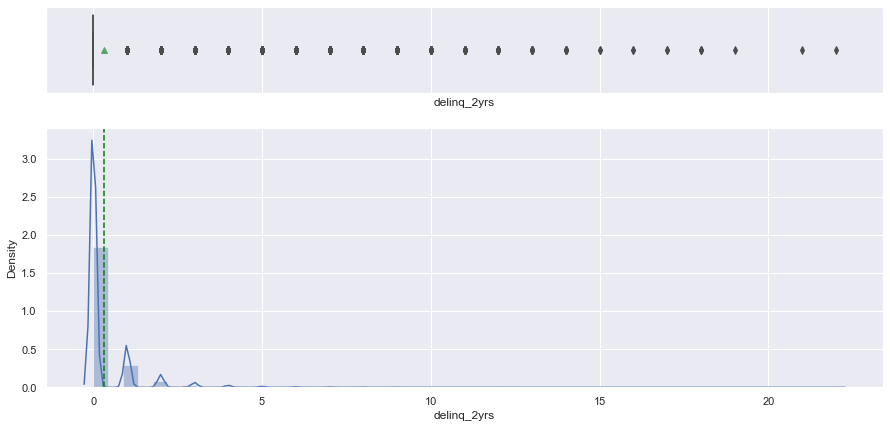

In [369]:
histogram_boxplot(df.delinq_2yrs)

### public_records

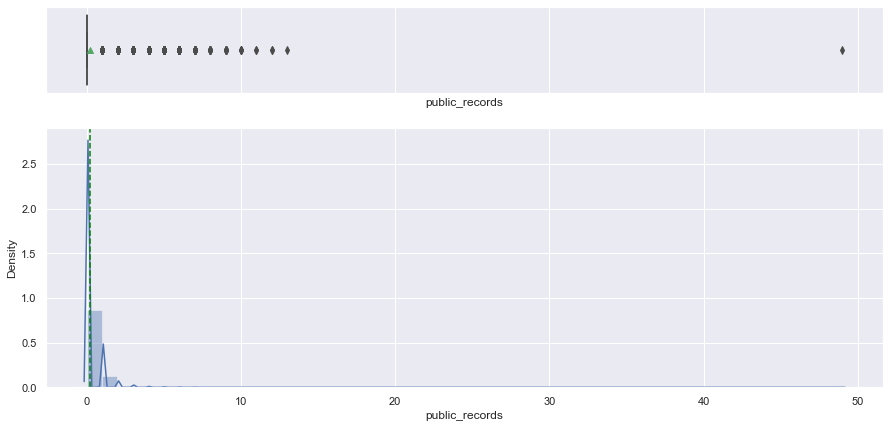

In [370]:
histogram_boxplot(df.public_records)

### total_acc

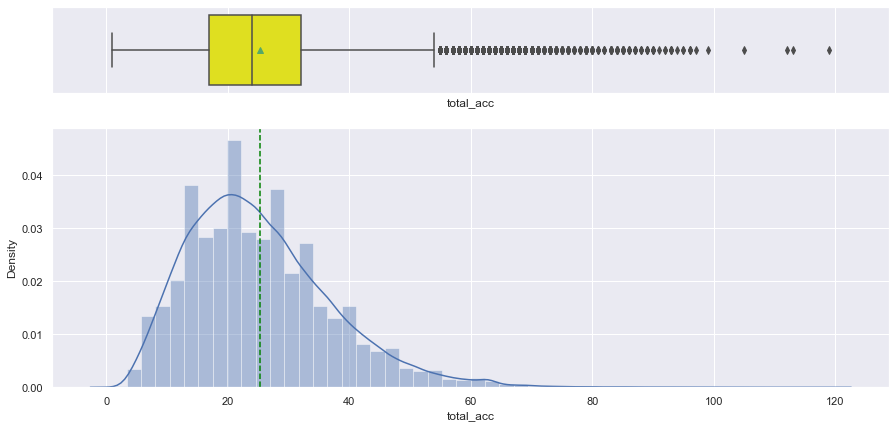

In [371]:
histogram_boxplot(df.total_acc)

### interest_receive

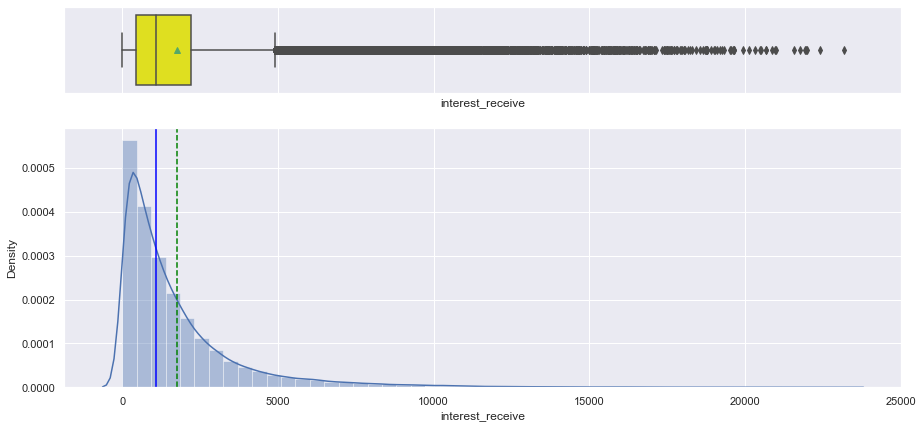

In [372]:
histogram_boxplot(df.interest_receive)

### last_week_pay

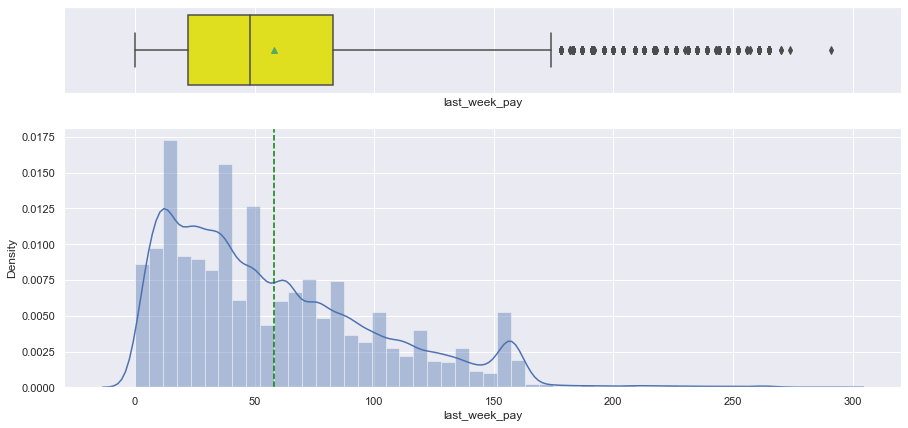

In [373]:
histogram_boxplot(df.last_week_pay)

### total_current_balance

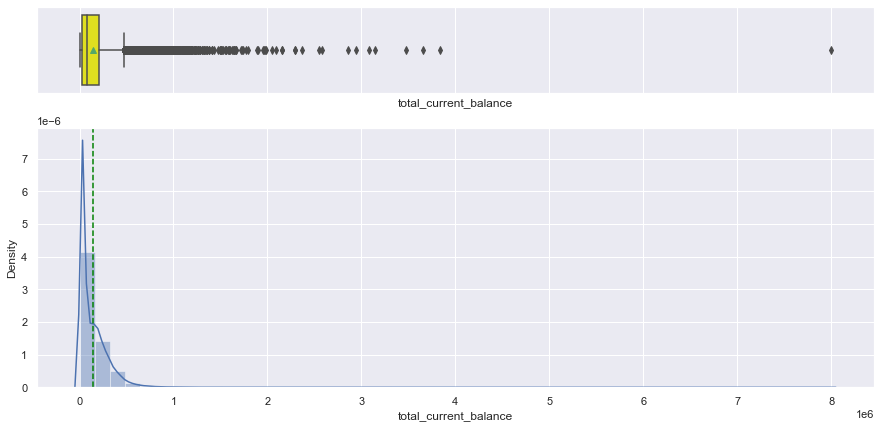

In [374]:
histogram_boxplot(df.total_current_balance)

### total_revolving_limit

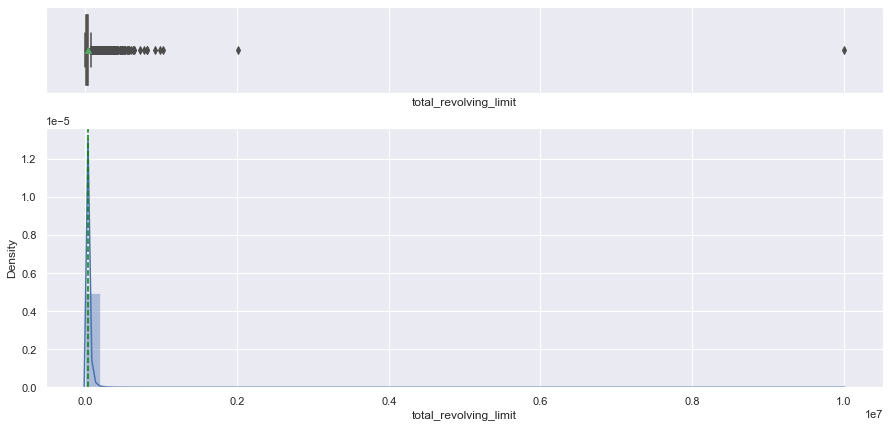

In [375]:
histogram_boxplot(df.total_revolving_limit)

### default

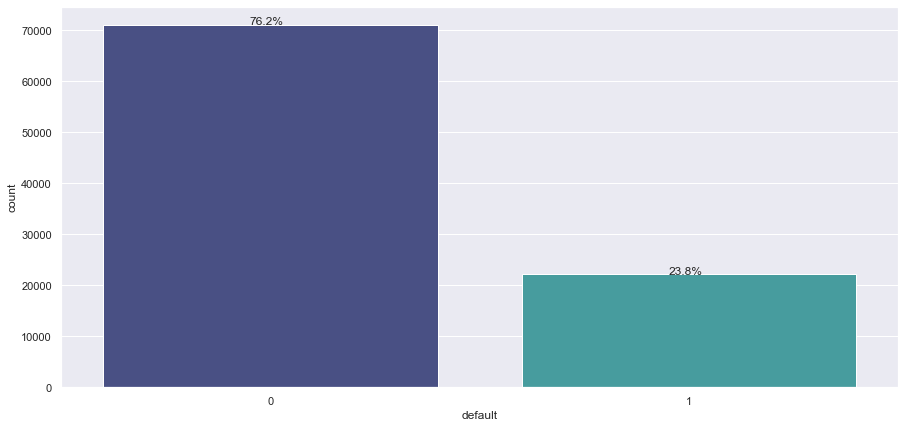

In [376]:
perc_on_bar(df.default)

### delinq_2yrs

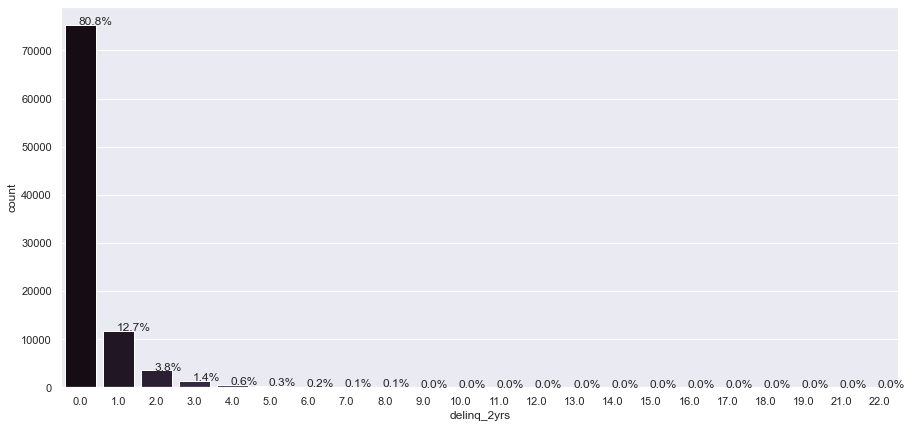

In [377]:
perc_on_bar(df.delinq_2yrs)

### public_records

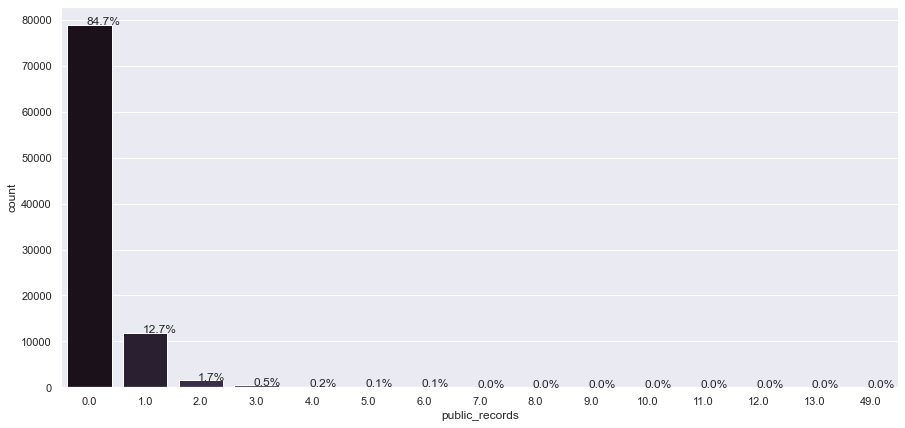

In [378]:
perc_on_bar(df.public_records)

### loan_term

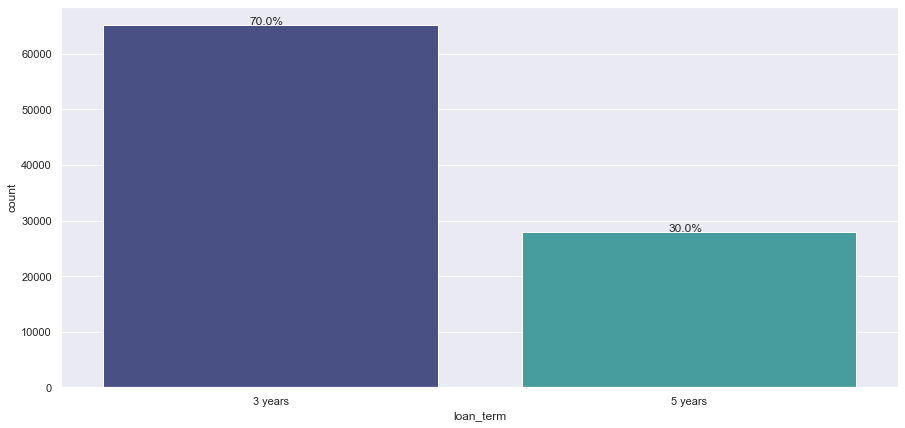

In [379]:
perc_on_bar(df.loan_term)

### loan_grade

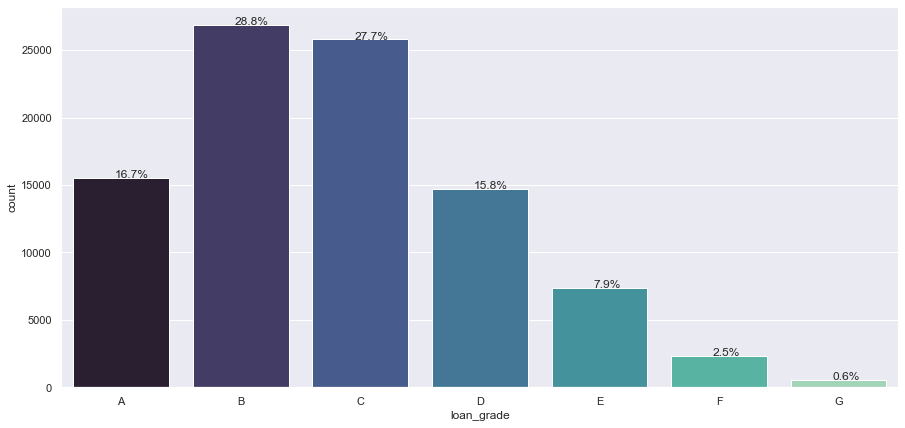

In [380]:
perc_on_bar(df.loan_grade)

### loan_subgrade

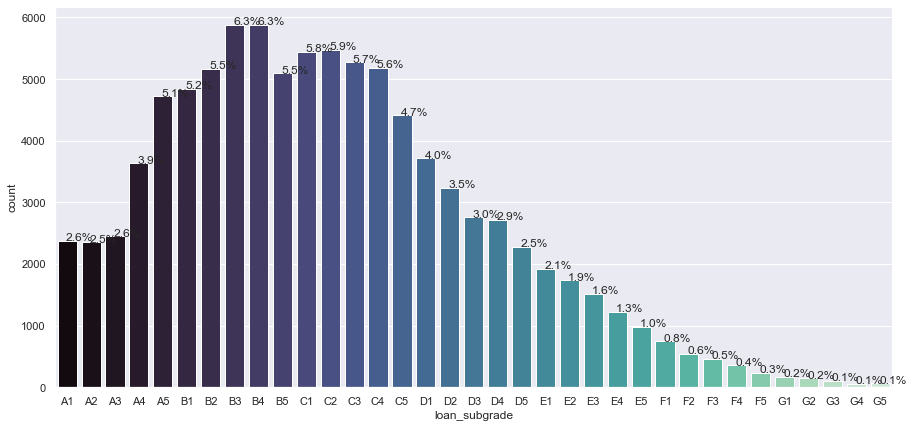

In [381]:
perc_on_bar(df.loan_subgrade)

### job_experience

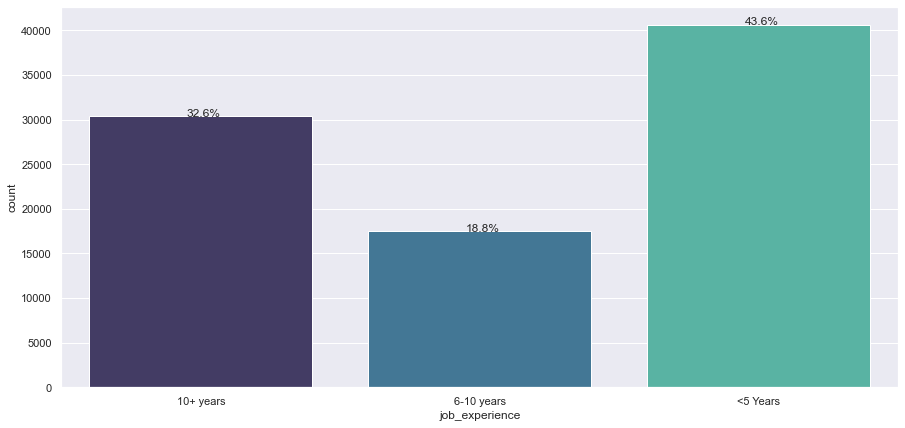

In [382]:
perc_on_bar(df.job_experience)

### home_ownership

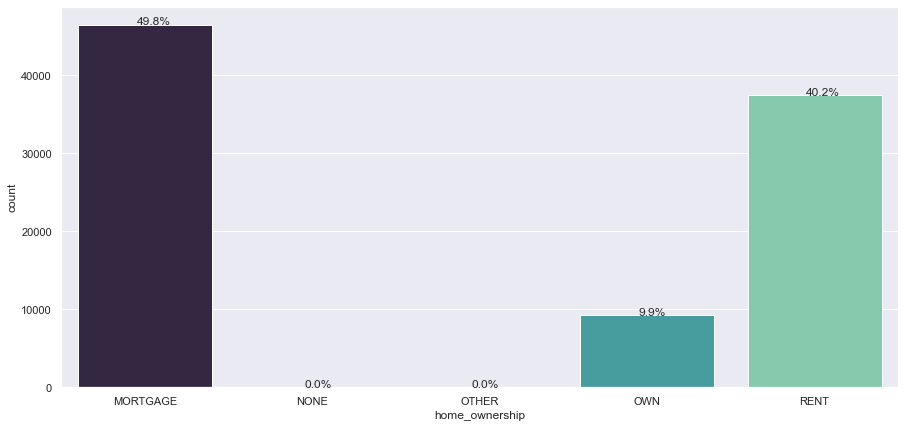

In [383]:
perc_on_bar(df.home_ownership)

### income_verification_status

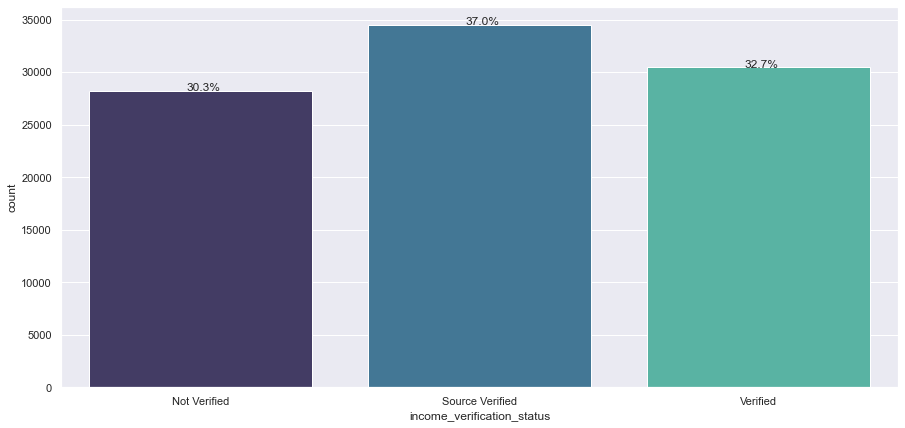

In [384]:
perc_on_bar(df.income_verification_status)

### loan_purpose

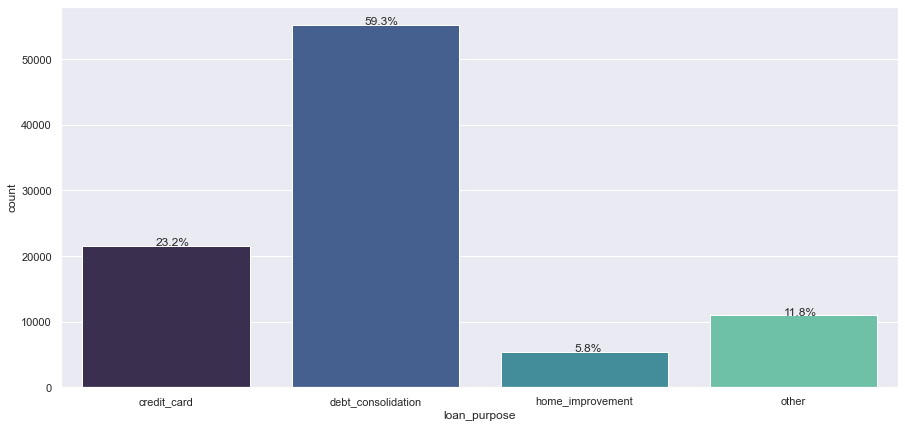

In [385]:
perc_on_bar(df.loan_purpose)

### state_code

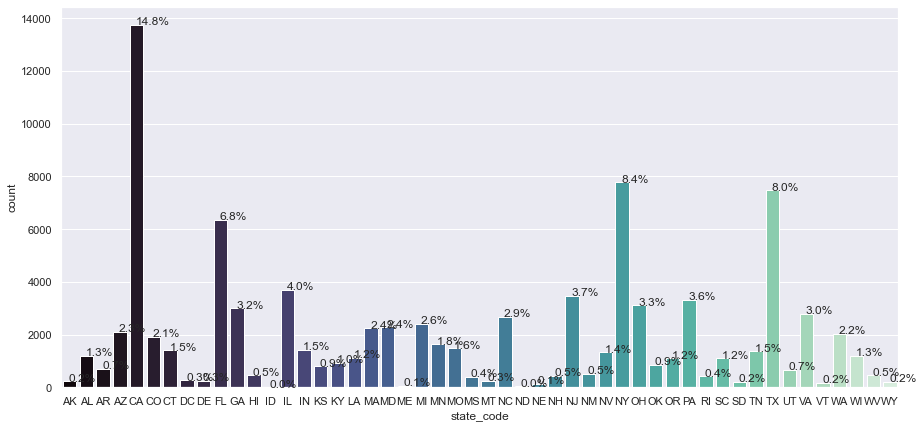

In [386]:
perc_on_bar(df.state_code)

### application_type

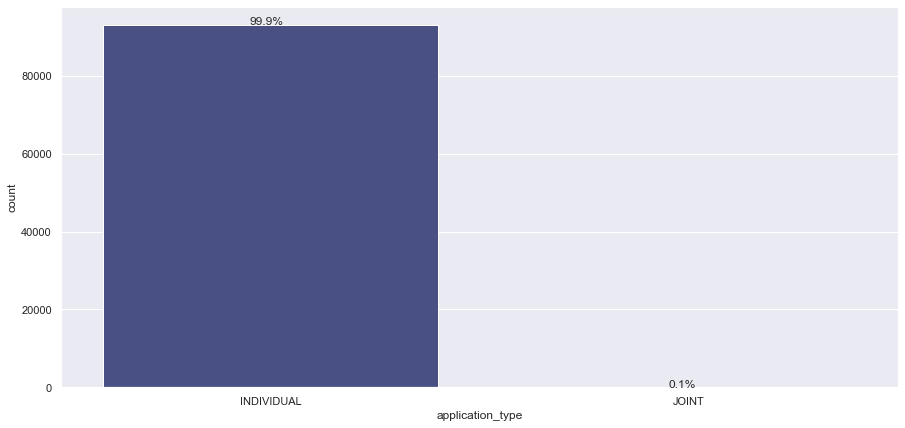

In [387]:
perc_on_bar(df.application_type)

### Bivariate Analysis

In [388]:
## Function to plot stacked bar chart
def stacked_plot(x, y, show_df=True):
    """
    Shows stacked plot from x and y pandas data series
    x: pandas data series
    y: pandas data series
    show_df: flag to show dataframe above plot (default=True)
    """
    if show_df == True:
        info = pd.crosstab(x, y, margins=True)
        info['% - 0'] = round(info[0]/info['All']*100, 2)
        info['% - 1'] = round(info[1]/info['All']*100, 2)
        display(info)
        
    pd.crosstab(x, y, normalize='index').plot(kind='bar', stacked=True, figsize=(10,5));

In [389]:
def show_boxplots(cols: list, feature: str, show_fliers=True, data=df): #method call to show bloxplots
    """
    Shows boxplots from pandas data series
    cols: list of column names
    feature: dataframe categorical feature
    """
    n_rows = math.ceil(len(cols)/3)
    plt.figure(figsize=(15, n_rows*5))
    for i, variable in enumerate(cols):
        plt.subplot(n_rows, 3, i+1)
        if show_fliers:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=True) 
        else:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=False)
        plt.tight_layout()
        plt.title(variable, fontsize=12)
    plt.show()

In [390]:
### Function to plot distributions and Boxplots of customers
def plot_target(x, target='default'):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title('Distribution of DEFAULT')
    sns.distplot(data[(data[target] == 1)][x], ax=axs[0,0], color='teal')
    axs[0, 1].set_title('Distribution of NON-DEFAULT')
    sns.distplot(data[(data[target] == 0)][x],ax=axs[0,1], color='orange')
    axs[1,0].set_title('Boxplot w.r.t default-flag')
    sns.boxplot(data[target],data[x],ax=axs[1,0], palette='mako')
    axs[1,1].set_title('Boxplot w.r.t default-flag - Without outliers')
    sns.boxplot(data[target],data[x], ax=axs[1,1], showfliers=False, palette='mako')
    plt.tight_layout()
    plt.show()

### Heat map

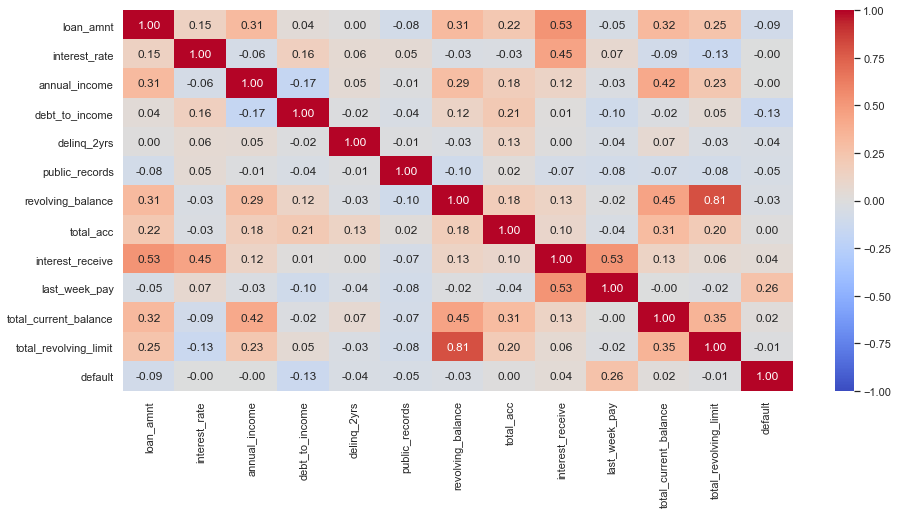

In [391]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='coolwarm');

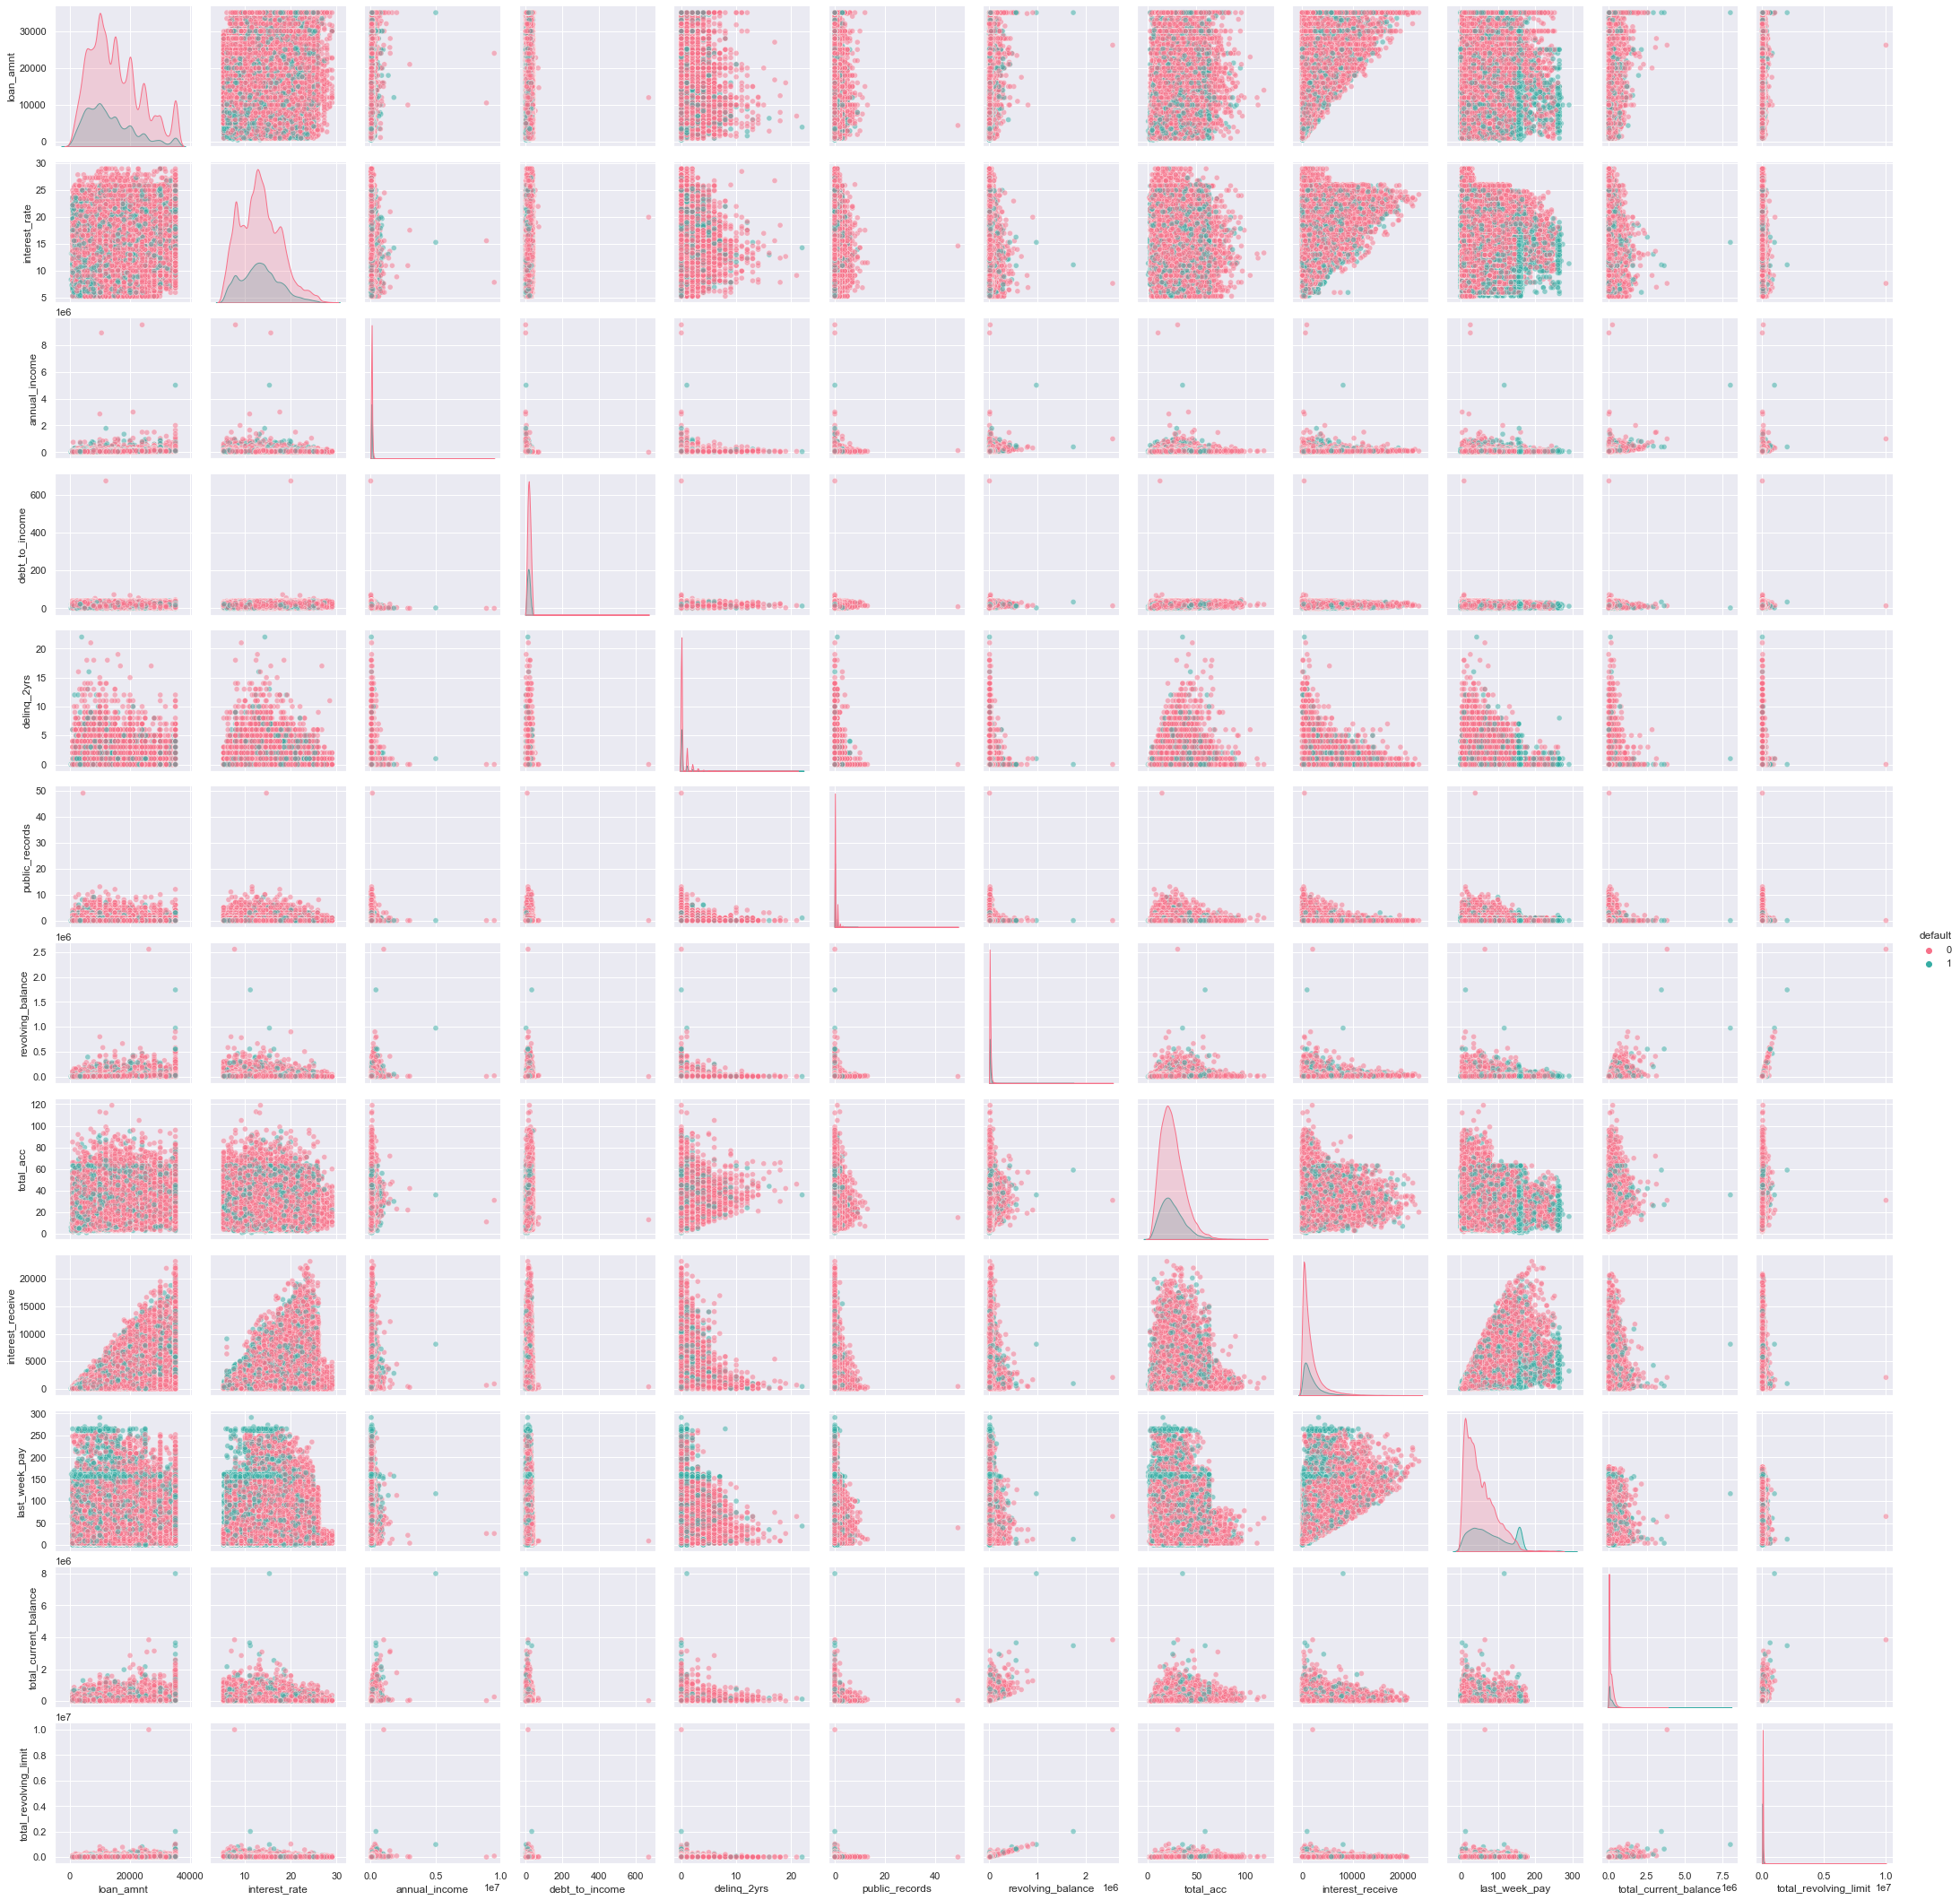

In [392]:
sns.pairplot(
    data=df, 
    hue='default',
    palette='husl',
    plot_kws={'alpha': 0.5}
);

### default vs loan_term

default        0      1    All  % - 0  % - 1
loan_term                                   
3 years    47345  17866  65211 72.600 27.400
5 years    23700   4263  27963 84.750 15.250
All        71045  22129  93174 76.250 23.750

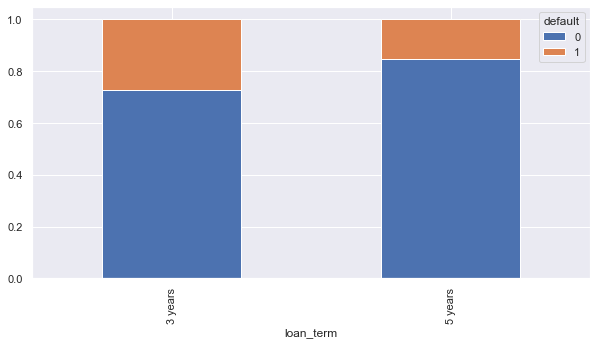

In [393]:
stacked_plot(df.loan_term, df.default)

### default vs loan_grade

default         0      1    All  % - 0  % - 1
loan_grade                                   
A           11281   4253  15534 72.620 27.380
B           19787   7078  26865 73.650 26.350
C           20203   5584  25787 78.350 21.650
D           11478   3237  14715 78.000 22.000
E            6003   1375   7378 81.360 18.640
F            1862    482   2344 79.440 20.560
G             431    120    551 78.220 21.780
All         71045  22129  93174 76.250 23.750

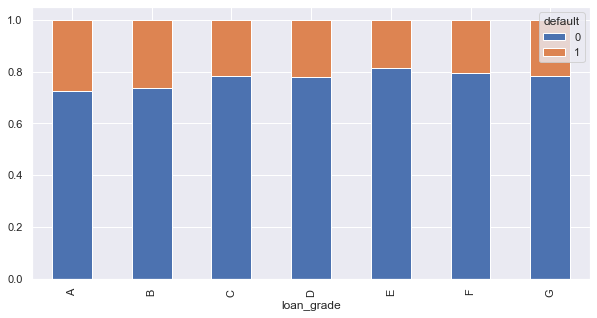

In [394]:
stacked_plot(df.loan_grade, df.default)

### default vs loan_subgrade

default            0      1    All  % - 0  % - 1
loan_subgrade                                   
A1              1780    597   2377 74.880 25.120
A2              1710    643   2353 72.670 27.330
A3              1731    719   2450 70.650 29.350
A4              2502   1129   3631 68.910 31.090
A5              3558   1165   4723 75.330 24.670
B1              3669   1174   4843 75.760 24.240
B2              3750   1419   5169 72.550 27.450
B3              4196   1683   5879 71.370 28.630
B4              4335   1544   5879 73.740 26.260
B5              3837   1258   5095 75.310 24.690
C1              4152   1291   5443 76.280 23.720
C2              4264   1215   5479 77.820 22.180
C3              4150   1120   5270 78.750 21.250
C4              4161   1021   5182 80.300 19.700
C5              3476    937   4413 78.770 21.230
D1              2932    784   3716 78.900 21.100
D2              2462    777   3239 76.010 23.990
D3              2114    645   2759 76.620 23.380
D4              2154    563   2717 79.280 20.720
D5              1816    468   2284 79.510 20.490
E1              1598    326   1924 83.060 16.940
E2              1436    300   1736 82.720 17.280
E3              1206    307   1513 79.710 20.290
E4               996    232   1228 81.110 18.890
E5               767    210    977 78.510 21.490
F1               590    155    745 79.190 20.810
F2               437    108    545 80.180 19.820
F3               363    102    465 78.060 21.940
F4               280     75    355 78.870 21.130
F5               192     42    234 82.050 17.950
G1               133     41    174 76.440 23.560
G2               118     28    146 80.820 19.180
G3                82     23    105 78.100 21.900
G4                46     14     60 76.670 23.330
G5                52     14     66 78.790 21.210
All            71045  22129  93174 76.250 23.750

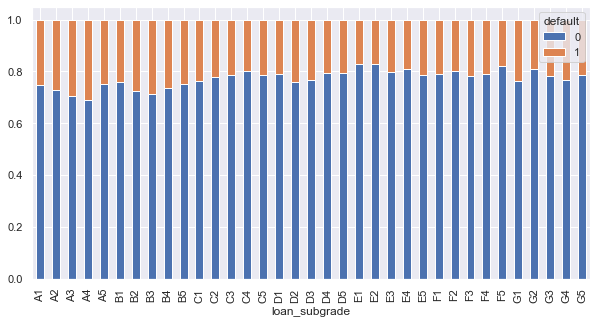

In [395]:
stacked_plot(df.loan_subgrade, df.default)

### default vs job_experience

default             0      1    All  % - 0  % - 1
job_experience                                   
10+ years       23656   6706  30362 77.910 22.090
6-10 years      13107   4393  17500 74.900 25.100
<5 Years        30377  10233  40610 74.800 25.200
All             67140  21332  88472 75.890 24.110

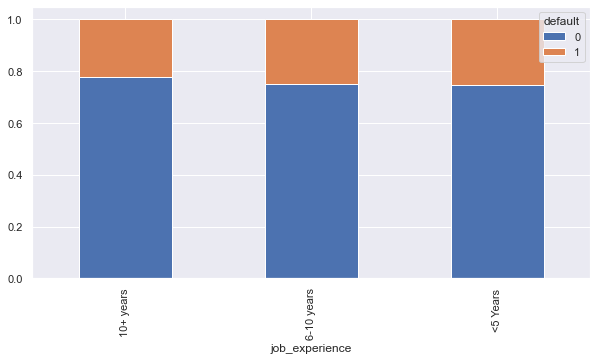

In [396]:
stacked_plot(df.job_experience, df.default)

### default vs home_ownership

default             0      1    All  % - 0  % - 1
home_ownership                                   
MORTGAGE        35316  11129  46445 76.040 23.960
NONE                2      6      8 25.000 75.000
OTHER               3     15     18 16.670 83.330
OWN              7323   1931   9254 79.130 20.870
RENT            28401   9048  37449 75.840 24.160
All             71045  22129  93174 76.250 23.750

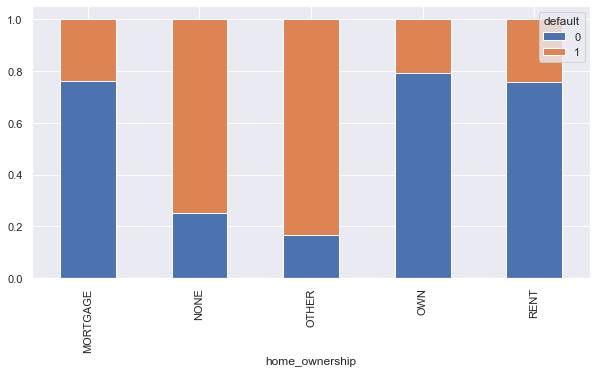

In [397]:
stacked_plot(df.home_ownership, df.default)

### default vs income_verification_status

default                         0      1    All  % - 0  % - 1
income_verification_status                                   
Not Verified                20329   7908  28237 71.990 28.010
Source Verified             28062   6425  34487 81.370 18.630
Verified                    22654   7796  30450 74.400 25.600
All                         71045  22129  93174 76.250 23.750

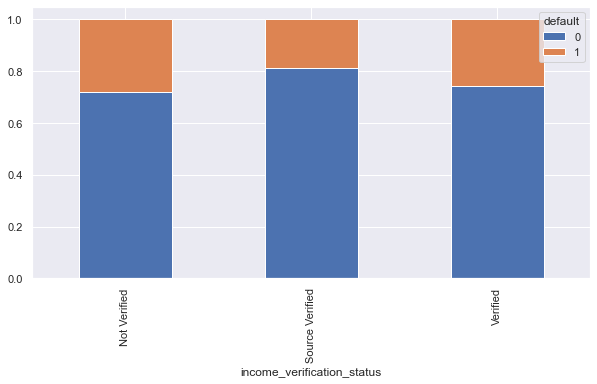

In [398]:
stacked_plot(df.income_verification_status, df.default)

### default vs loan_purpose


default                 0      1    All  % - 0  % - 1
loan_purpose                                         
credit_card         17006   4565  21571 78.840 21.160
debt_consolidation  42408  12833  55241 76.770 23.230
home_improvement     4068   1323   5391 75.460 24.540
other                7563   3408  10971 68.940 31.060
All                 71045  22129  93174 76.250 23.750

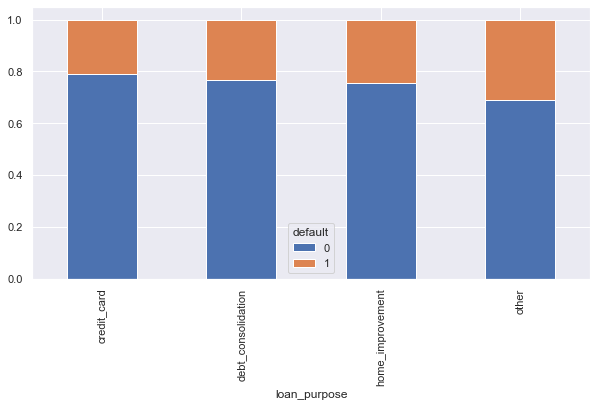

In [399]:
stacked_plot(df.loan_purpose, df.default)

### default vs state_code

default         0      1    All   % - 0   % - 1
state_code                                     
AK            170     61    231  73.590  26.410
AL            915    273   1188  77.020  22.980
AR            536    158    694  77.230  22.770
AZ           1583    532   2115  74.850  25.150
CA           9905   3839  13744  72.070  27.930
CO           1431    493   1924  74.380  25.620
CT           1083    319   1402  77.250  22.750
DC            183     88    271  67.530  32.470
DE            195     51    246  79.270  20.730
FL           4876   1484   6360  76.670  23.330
GA           2324    674   2998  77.520  22.480
HI            327    124    451  72.510  27.490
ID              0      1      1   0.000 100.000
IL           2864    835   3699  77.430  22.570
IN           1188    232   1420  83.660  16.340
KS            638    162    800  79.750  20.250
KY            731    202    933  78.350  21.650
LA            854    258   1112  76.800  23.200
MA           1648    584   2232  73.840  26.160
MD           1704    575   2279  74.770  25.230
ME             57      2     59  96.610   3.390
MI           1911    504   2415  79.130  20.870
MN           1254    384   1638  76.560  23.440
MO           1144    341   1485  77.040  22.960
MS            357     32    389  91.770   8.230
MT            198     55    253  78.260  21.740
NC           2050    619   2669  76.810  23.190
ND             45      0     45 100.000   0.000
NE            124      2    126  98.410   1.590
NH            337    110    447  75.390  24.610
NJ           2640    824   3464  76.210  23.790
NM            403    104    507  79.490  20.510
NV            983    343   1326  74.130  25.870
NY           5886   1896   7782  75.640  24.360
OH           2467    637   3104  79.480  20.520
OK            664    187    851  78.030  21.970
OR            805    297   1102  73.050  26.950
PA           2616    705   3321  78.770  21.230
RI            313     99    412  75.970  24.030
SC            847    261   1108  76.440  23.560
SD            150     48    198  75.760  24.240
TN           1168    197   1365  85.570  14.430
TX           5748   1719   7467  76.980  23.020
UT            465    193    658  70.670  29.330
VA           2141    652   2793  76.660  23.340
VT            129     45    174  74.140  25.860
WA           1517    521   2038  74.440  25.560
WI            940    266   1206  77.940  22.060
WV            368     92    460  80.000  20.000
WY            163     49    212  76.890  23.110
All         71045  22129  93174  76.250  23.750

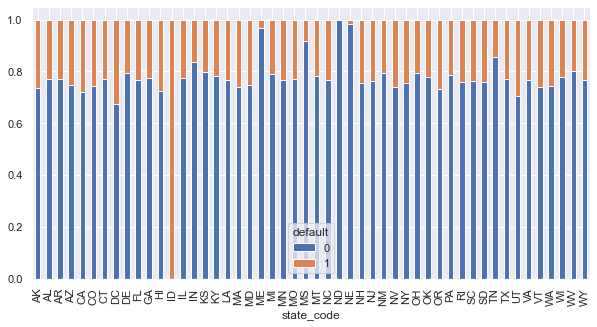

In [400]:
stacked_plot(df.state_code, df.default)

 With outliers 
 **************************************************


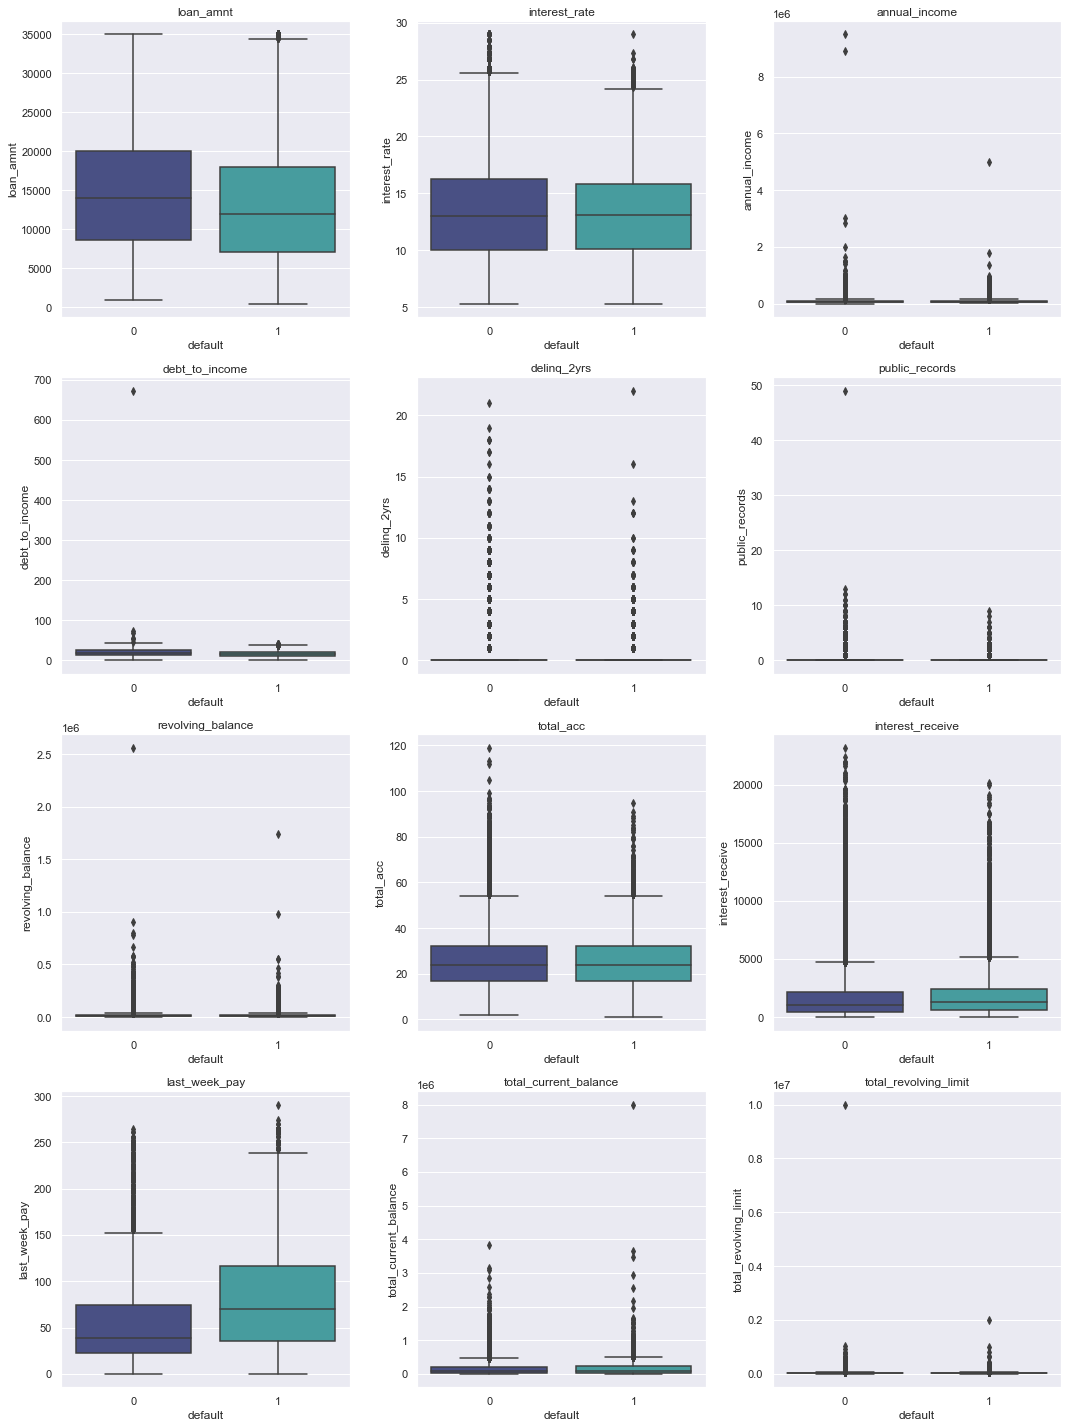

In [401]:
cols = df.select_dtypes(include=['integer', 'float']).columns.tolist()
cols.remove('default')
print(' With outliers','\n','*'*50)
show_boxplots(cols=cols, feature='default')

 Without outliers 
 **************************************************


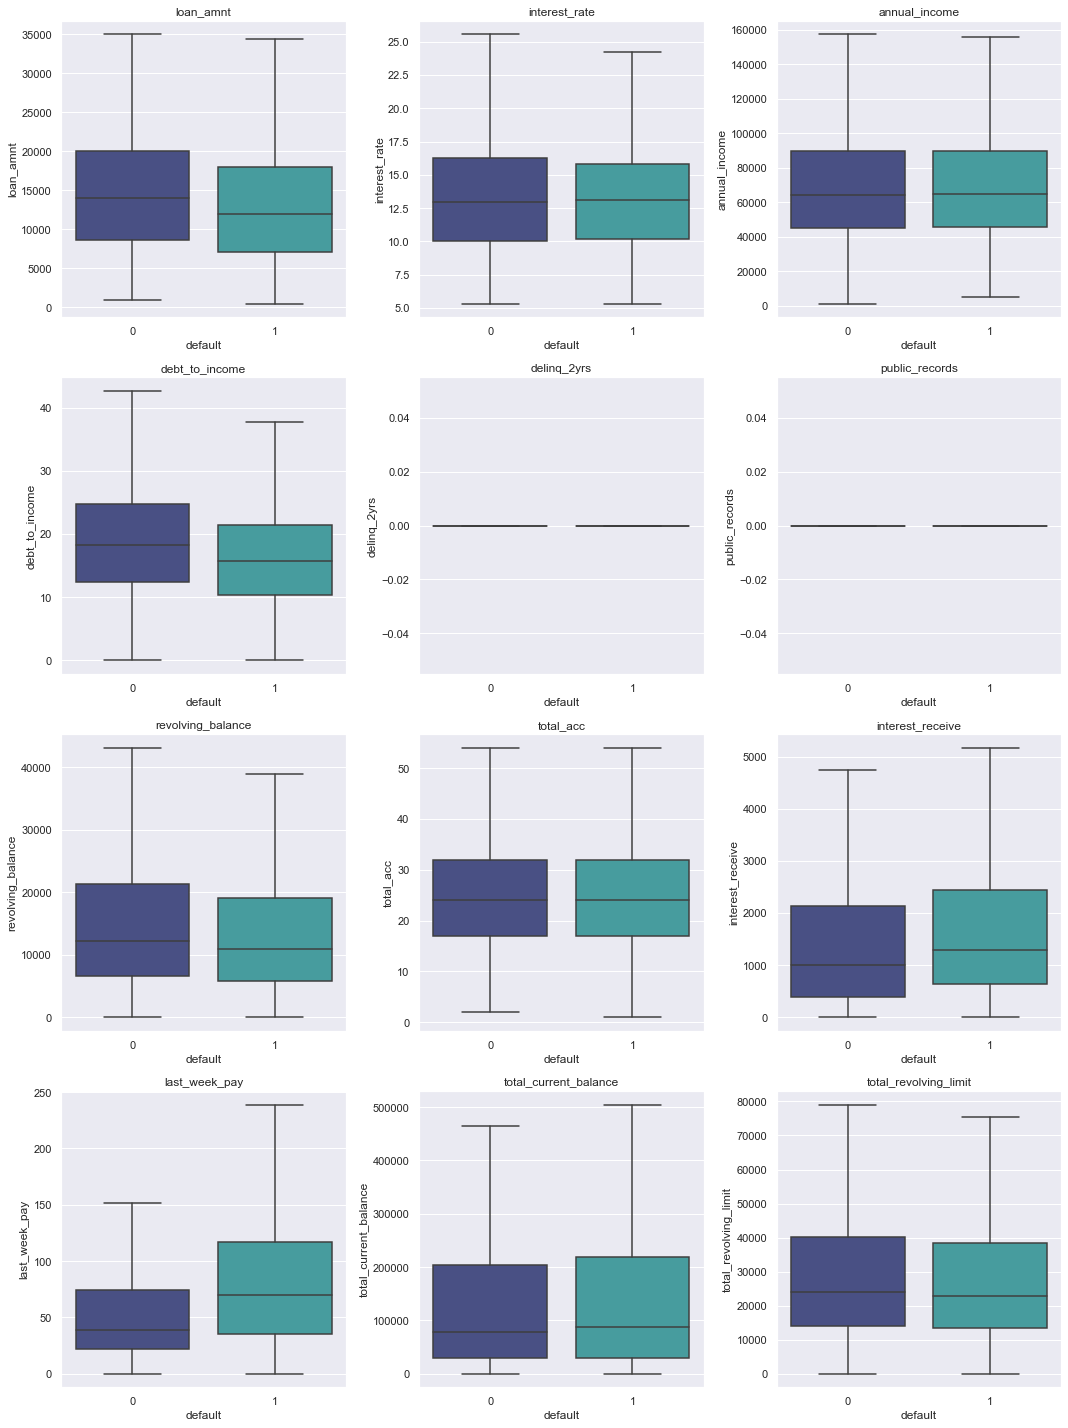

In [402]:
print(' Without outliers','\n','*'*50)
show_boxplots(cols=cols, feature='default', show_fliers=False)

### default vs loan_amnt

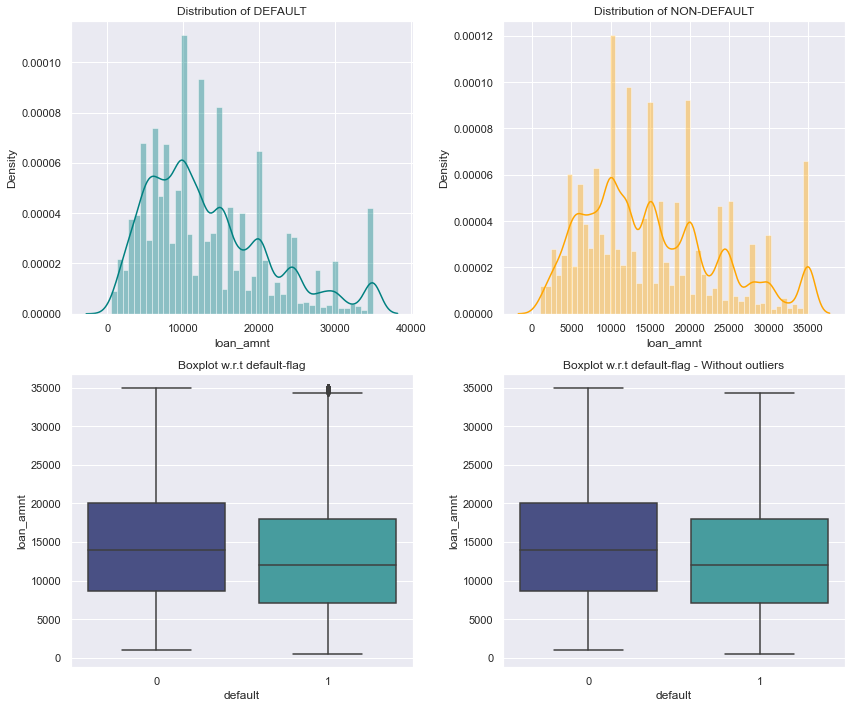

In [403]:
plot_target('loan_amnt')

### default vs interest_rate

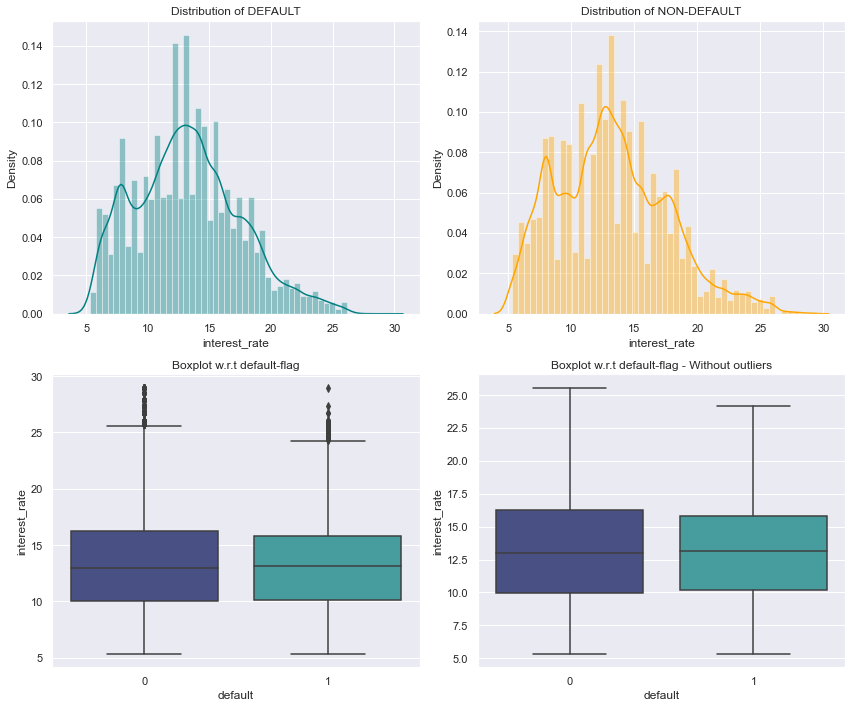

In [404]:
plot_target('interest_rate')

### default vs annual_income

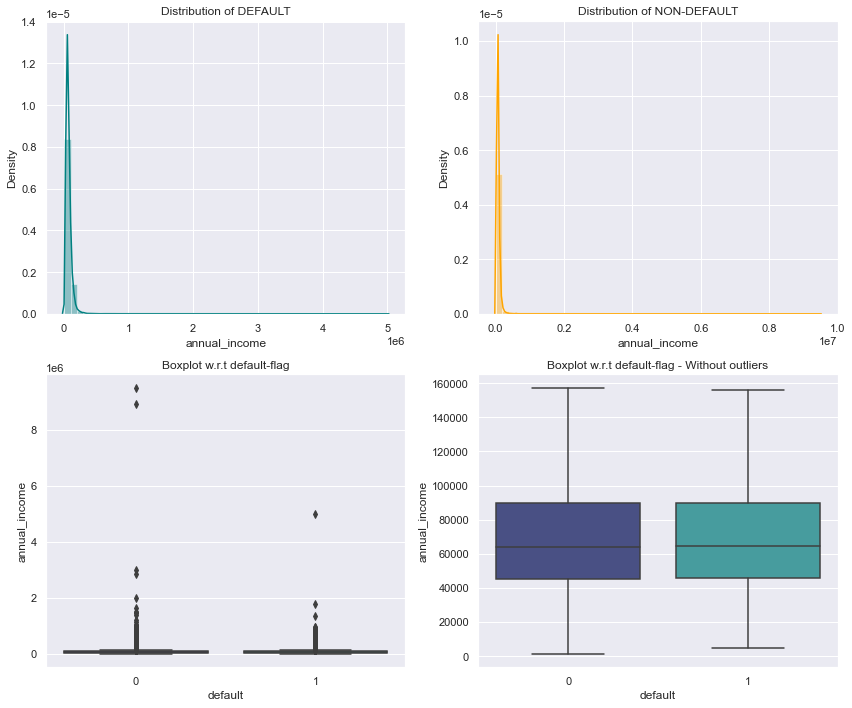

In [405]:
plot_target('annual_income')

### default vs debt_to_income

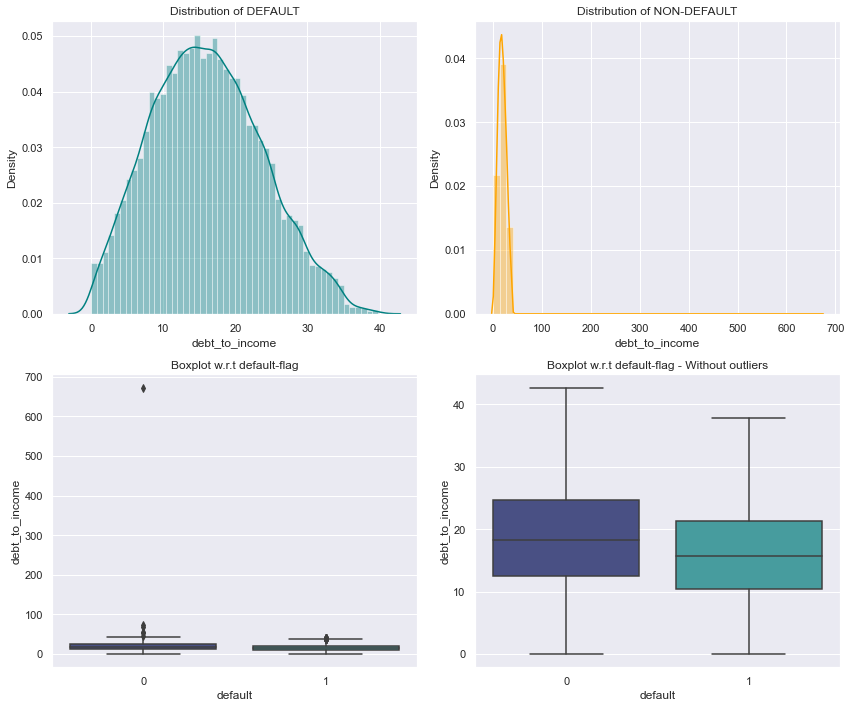

In [406]:
plot_target('debt_to_income')

### default vs delinq_2yrs

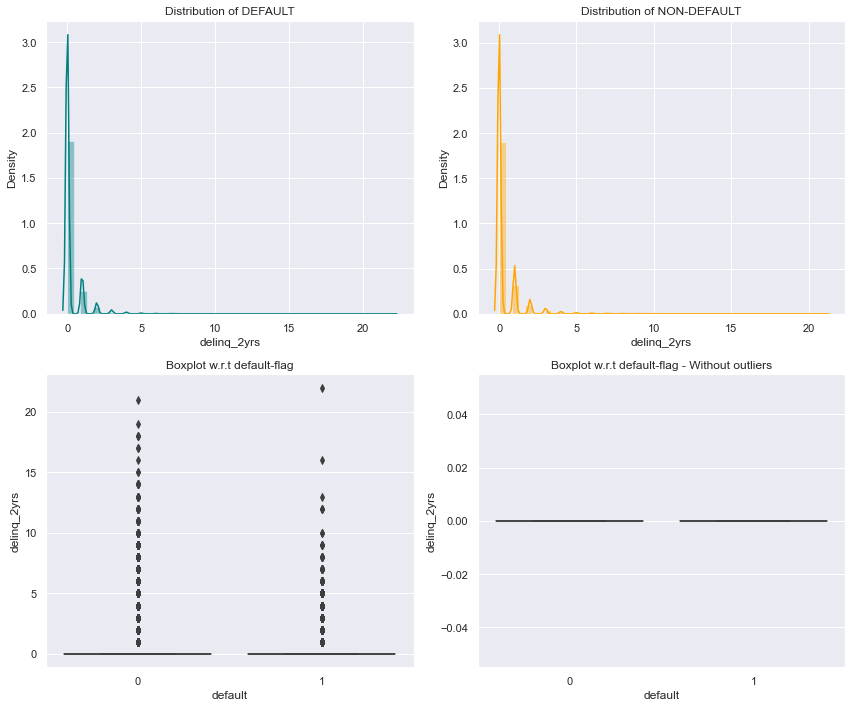

In [407]:
plot_target('delinq_2yrs')

### default vs public_records

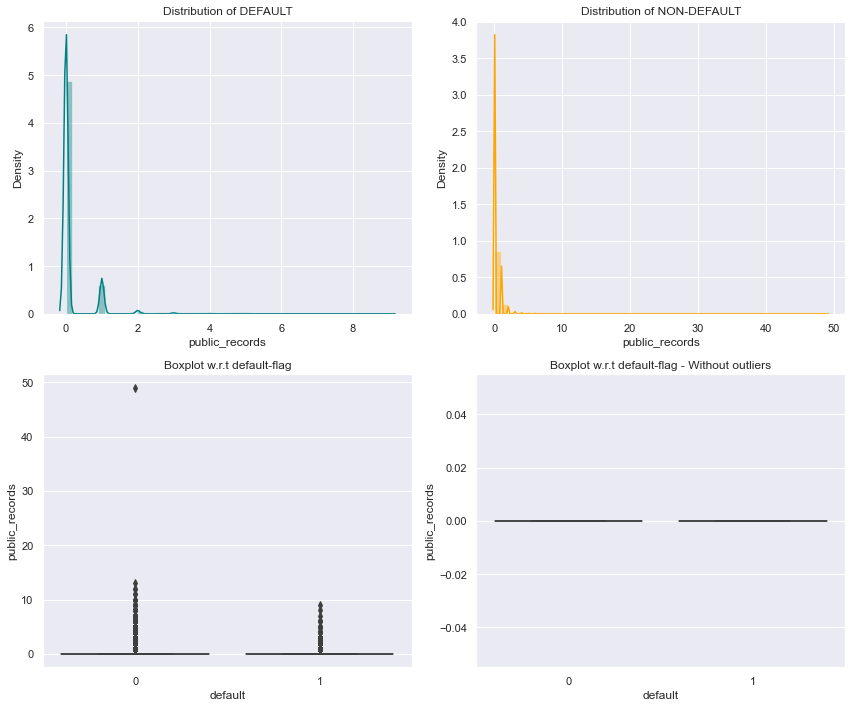

In [408]:
plot_target('public_records')

### default vs revolving_balance

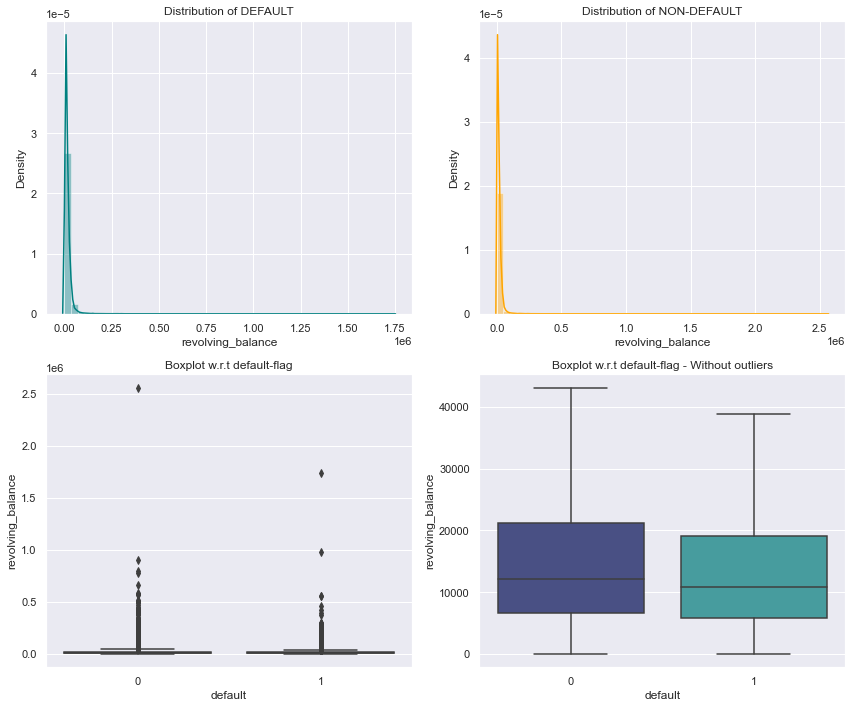

In [409]:
plot_target('revolving_balance')

### default vs total_acc

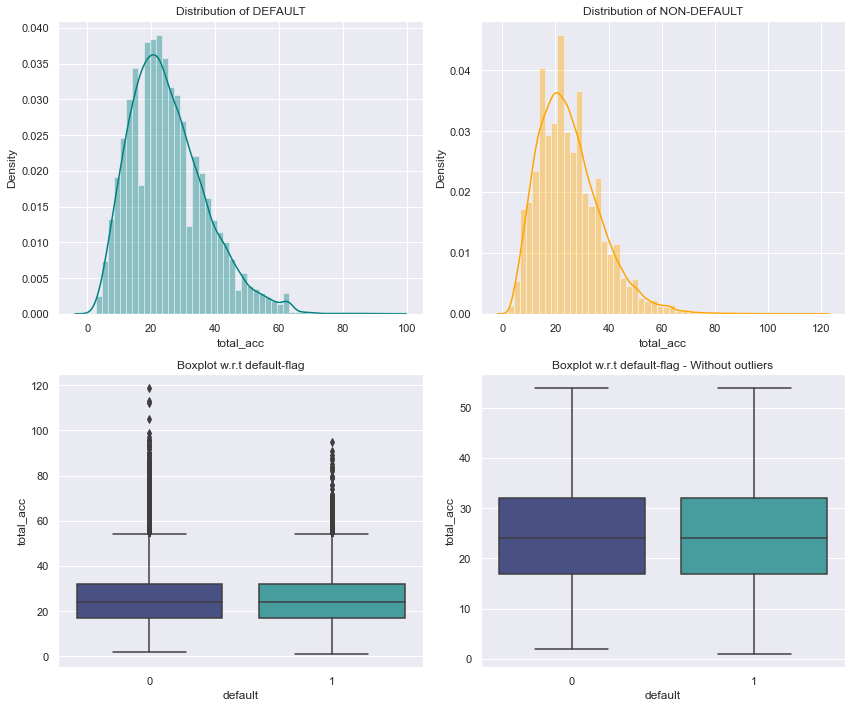

In [410]:
plot_target('total_acc')

### default vs interest_receive

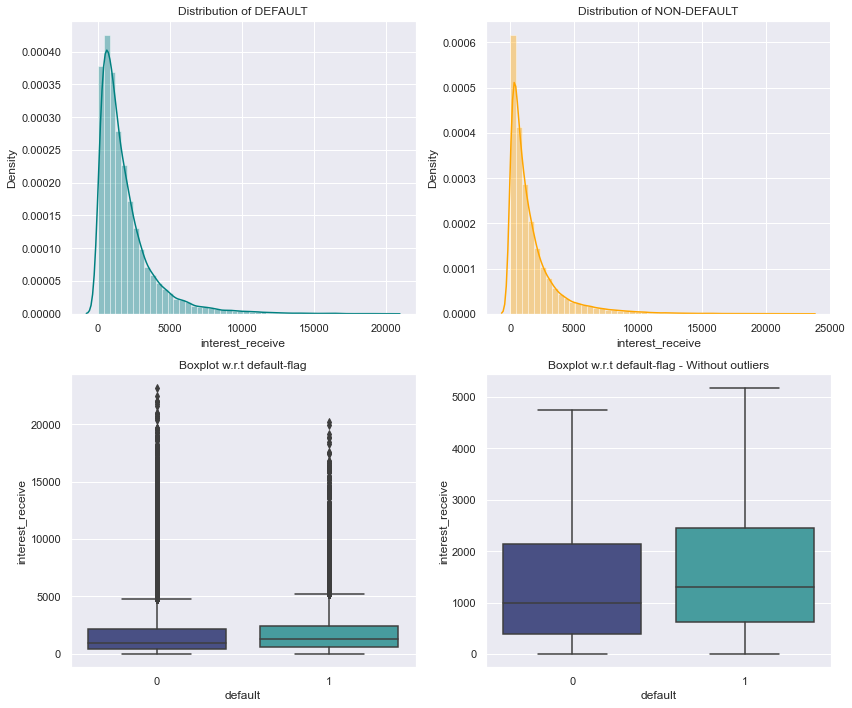

In [411]:
plot_target('interest_receive')

### default vs last_week_pay

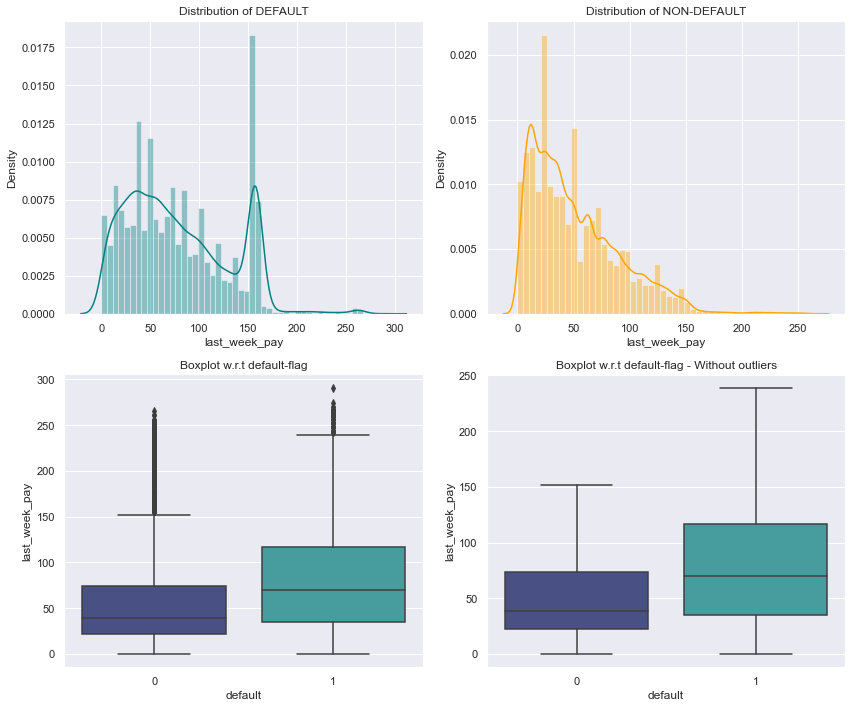

In [412]:
plot_target('last_week_pay')

### default vs total_current_balance

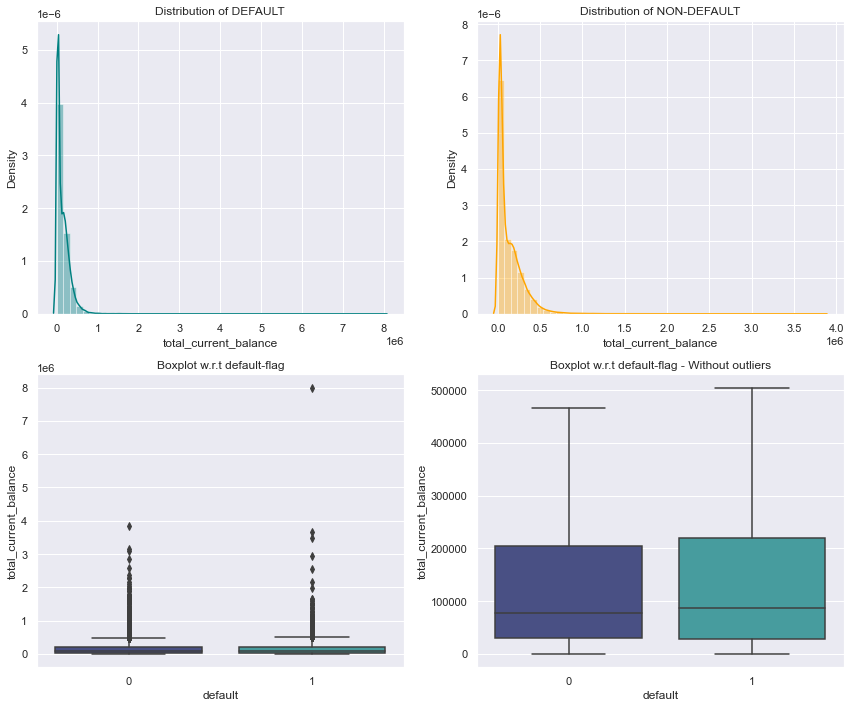

In [413]:
plot_target('total_current_balance')

### default vs total_revolving_limit

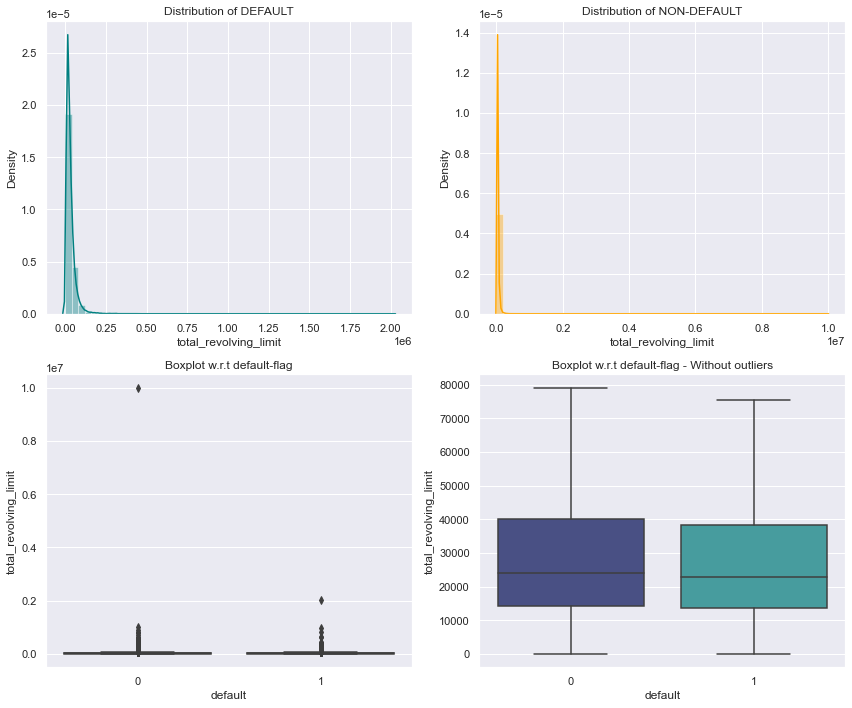

In [414]:
plot_target('total_revolving_limit')

In [415]:
def show_violinplot(cols: list, feature: str, hue=df.default, data=df, show_fliers=True):
    #plt.figure(figsize=(12,10))
    for i, variable in enumerate(cols):
        plt.subplot(2, 2, i+1)
        sns.violinplot(data[feature], 
                       data[variable],
                       hue=hue,
                       ci=0,
                       show_fliers=show_fliers)
        plt.tight_layout()
        plt.title(variable);

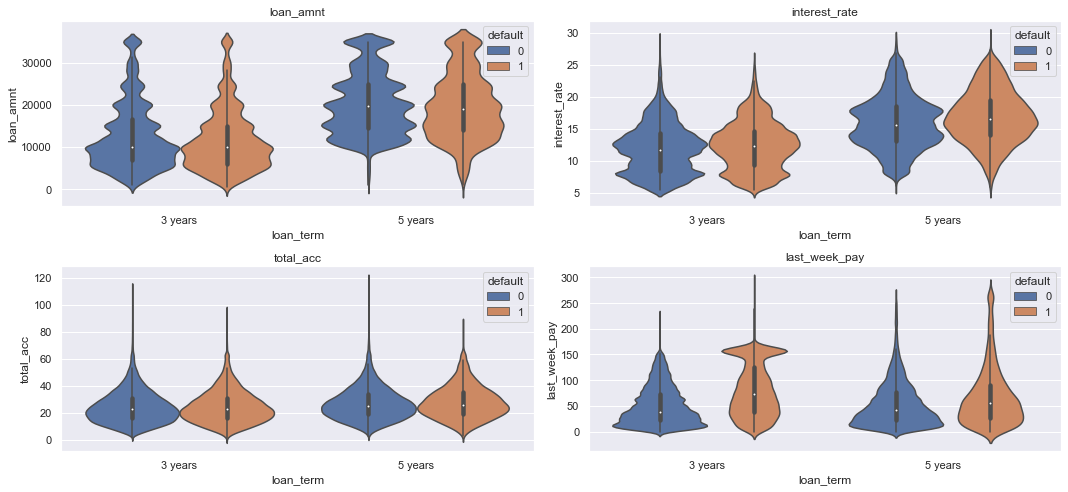

In [416]:
cols = ['loan_amnt', 'interest_rate', 'total_acc', 'last_week_pay']
show_violinplot(cols, 'loan_term')

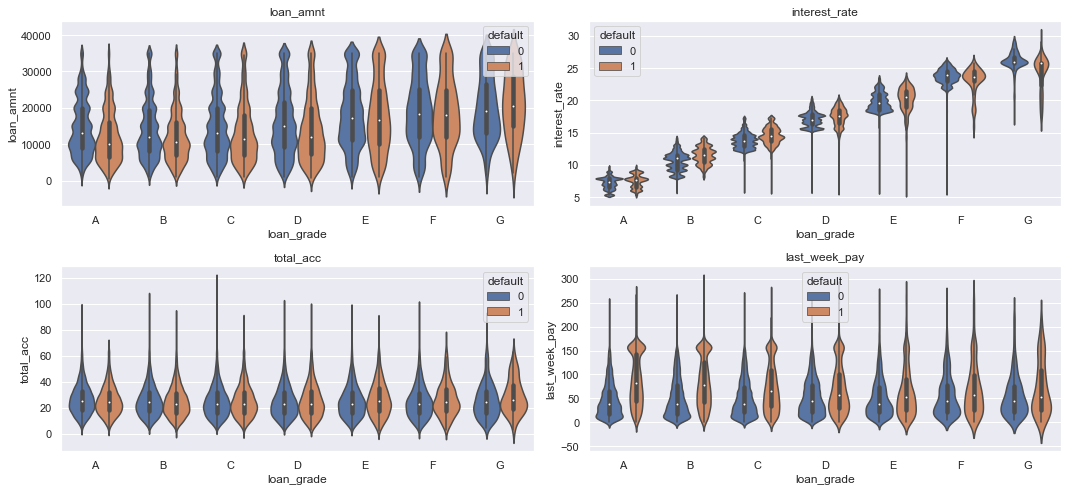

In [417]:
show_violinplot(cols, 'loan_grade', show_fliers=False)

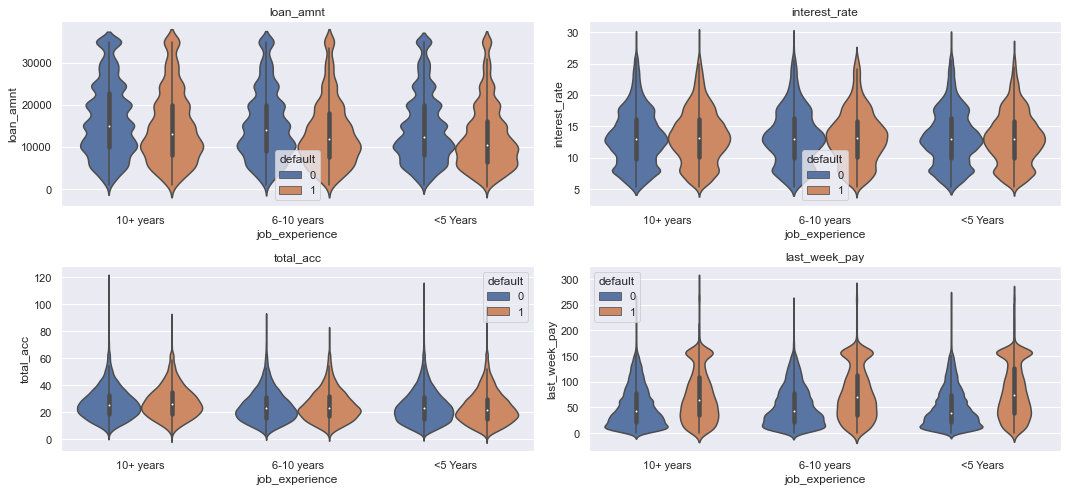

In [418]:
show_violinplot(cols, 'job_experience', show_fliers=False)

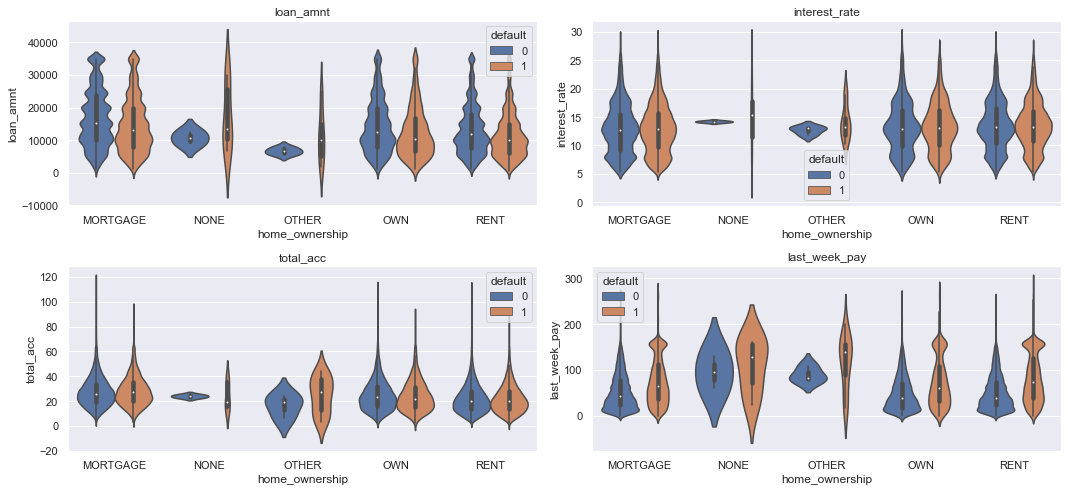

In [419]:
show_violinplot(cols, 'home_ownership', show_fliers=False)

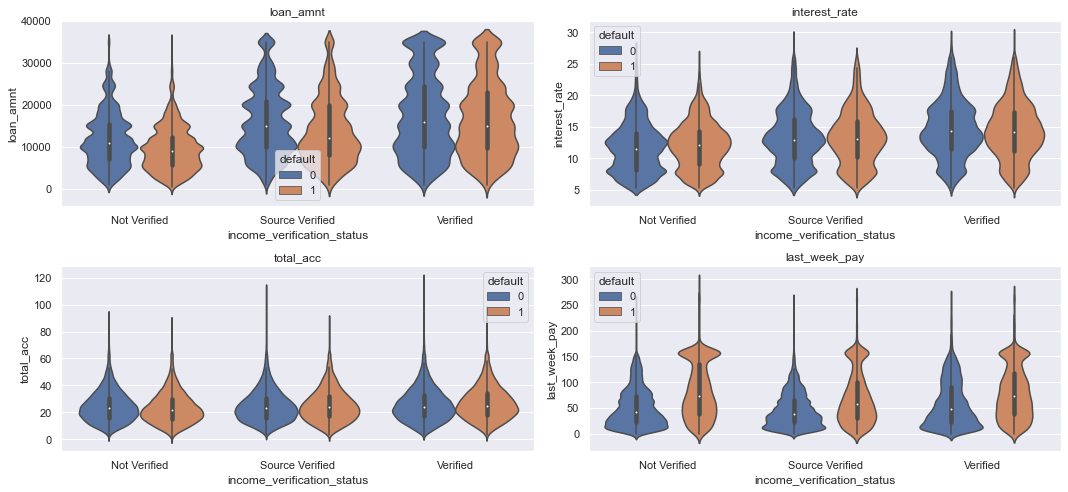

In [420]:
show_violinplot(cols, 'income_verification_status', show_fliers=False)

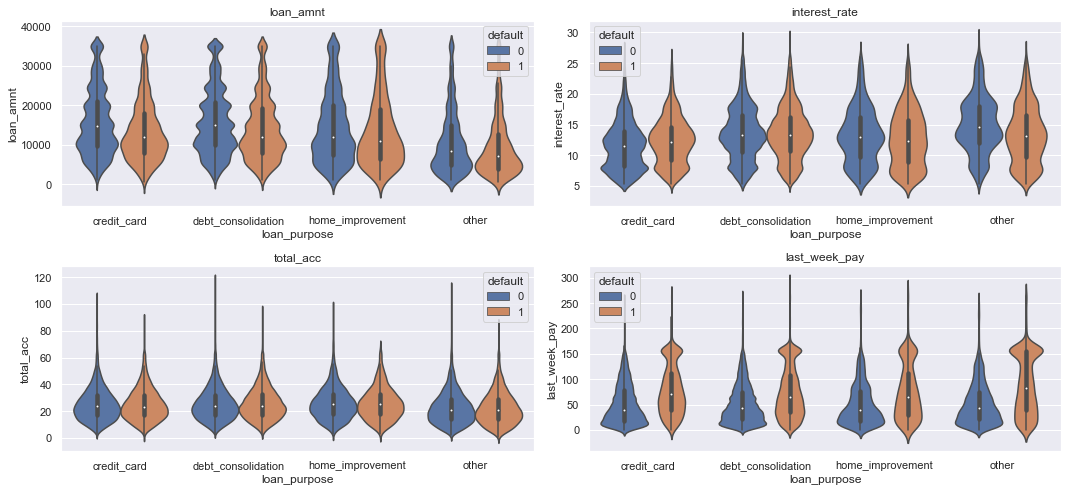

In [421]:
show_violinplot(cols, 'loan_purpose', show_fliers=False)

In [422]:
Q1 = data.quantile(0.25) # To find the 25th percentile and 75th percentile.
Q3 = data.quantile(0.75)
IQR = Q3 - Q1            # Inter Quantile Range (75th perentile - 25th percentile)
lower = Q1-1.5 * IQR     # Finding lower and upper bounds for all values. All values outside these bounds are outliers
upper = Q3+1.5 * IQR
df_lower = (data.select_dtypes(include=['float64','int64']) < lower)
df_upper = (data.select_dtypes(include=['float64','int64']) > upper)
(df_lower | df_upper).sum()/len(data)*100

ID                       0.000
loan_amnt                0.000
interest_rate            0.655
annual_income            4.509
debt_to_income           0.010
delinq_2yrs             19.165
public_records          15.281
revolving_balance        5.414
total_acc                2.093
interest_receive         7.262
last_week_pay            0.763
total_current_balance    3.162
total_revolving_limit    5.326
default                 23.750
dtype: float64

<a id=processing></a>
## <span style="color:blue">Data Preparation</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [423]:
df.isnull().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                4702
home_ownership                   0
annual_income                    1
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      2
public_records                   2
revolving_balance                0
total_acc                        2
interest_receive                 0
application_type                 0
last_week_pay                 1924
total_current_balance         7386
total_revolving_limit         7386
default                          0
dtype: int64

In [458]:
for i in df.select_dtypes(include=['category']).columns:
    print('Unique values in', i, 'are :')
    print(df[i].value_counts(dropna=False))
    print('*'*50)

Unique values in loan_term are :
3 years    65211
5 years    27963
Name: loan_term, dtype: int64
**************************************************
Unique values in loan_grade are :
B    26865
C    25787
A    15534
D    14715
E     7378
F     2344
G      551
Name: loan_grade, dtype: int64
**************************************************
Unique values in loan_subgrade are :
B4    5879
B3    5879
C2    5479
C1    5443
C3    5270
C4    5182
B2    5169
B5    5095
B1    4843
A5    4723
C5    4413
D1    3716
A4    3631
D2    3239
D3    2759
D4    2717
A3    2450
A1    2377
A2    2353
D5    2284
E1    1924
E2    1736
E3    1513
E4    1228
E5     977
F1     745
F2     545
F3     465
F4     355
F5     234
G1     174
G2     146
G3     105
G5      66
G4      60
Name: loan_subgrade, dtype: int64
**************************************************
Unique values in job_experience are :
<5 Years      40610
10+ years     30362
6-10 years    17500
NaN            4702
Name: job_experience, dtype: int64

In [662]:
# df1.home_ownership.replace('NONE','OTHER', inplace=True)
# df1.home_ownership.value_counts().sort_values(ascending=False)

In [663]:
# df1.income_verification_status.replace('Source Verified','Verified', inplace=True)
# df1.income_verification_status.value_counts().sort_values(ascending=False)

In [664]:
# df1['state_code'] = df1['state_code'].apply(region_combining)
# df1['state_code'] = df1['state_code'].astype('category')
# df1.state_code.value_counts(dropna=False)

#midwest = ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
#northeast = ['CT', 'MA', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
#south = ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK',
#         'SC', 'TN', 'TX', 'VA', 'WV']
#west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

### Missing value treatment

In [735]:
df1 = df.copy()

In [736]:
df1.annual_income.fillna(df.annual_income.mean(), inplace=True)
df1.last_week_pay.fillna(df.last_week_pay.mean(), inplace=True)
df1.total_current_balance.fillna(df.total_current_balance.mean(), inplace=True)
df1.total_revolving_limit.fillna(df.total_revolving_limit.mean(), inplace=True)
df1.total_acc.fillna(df.total_acc.mean(), inplace=True)

In [737]:
job_experience = {'<5 Years':0, '6-10 years':1, '10+ years':2}
df1['job_experience'] = df1['job_experience'].map(job_experience).astype('Int32')

loan_term = {'3 years': 0, '5 years': 1}
df1['loan_term'] = df1['loan_term'].map(loan_term).astype('Int32')

loan_grade = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
df1['loan_grade'] = df1['loan_grade'].map(loan_grade).astype('Int32')

loan_subgrade = {'A1':0,  'A2':1,  'A3':2,  'A4':3,  'A5':4, 
                 'B1':5,  'B2':6,  'B3':7,  'B4':8,  'B5':9, 
                 'C1':10, 'C2':11, 'C3':12, 'C4':13, 'C5':14,
                 'D1':15, 'D2':16, 'D3':17, 'D4':18, 'D5':19,
                 'E1':20, 'E2':21, 'E3':22, 'E4':23, 'E5':24,
                 'F1':25, 'F2':26, 'F3':27, 'F4':28, 'F5':29,
                 'G1':30, 'G2':31, 'G3':32, 'G4':33, 'G5':34}
df1['loan_subgrade'] = df1['loan_subgrade'].map(loan_subgrade).astype('Int32')

home_ownership = {'MORTGAGE':0, 'RENT':1, 'OWN':2, 'OTHER':3, 'NONE':4}
df1['home_ownership'] = df1['home_ownership'].map(home_ownership).astype('Int32')

income_verification_status = {'Verified':0, 'Not Verified':1, 'Source Verified':2}
df1['income_verification_status'] = df1['income_verification_status'].map(income_verification_status).astype('Int32')

loan_purpose = {'debt_consolidation': 0, 'credit_card':1, 'home_improvement': 2, 'other': 3}
df1['loan_purpose'] = df1['loan_purpose'].map(loan_purpose).astype('Int32')

application_type = {'INDIVIDUAL': 0, 'JOINT':1}
df1['application_type'] = df1['application_type'].map(application_type).astype('Int32')

state_code = {'AK':0,  'AL':1,  'AR':2,  'AZ':3,  'CA':4 , 'CO':5,  'CT':6,  'DC':7,  'DE':8, 
              'FL':9,  'GA':10, 'HI':11, 'IA':12, 'ID':13, 'IL':14, 'IN':15, 'KS':16, 'KY':17, 
              'LA':18, 'MA':19, 'MD':20, 'ME':21, 'MI':22, 'MN':23, 'MO':24, 'MS':25, 'MT':26, 
              'NC':27, 'ND':28, 'NE':29, 'NH':30, 'NJ':31, 'NM':32, 'NV':33, 'NY':34, 'OH':35, 
              'OK':36, 'OR':37, 'PA':38, 'RI':39, 'SC':40, 'SD':41, 'TN':42, 'TX':43, 'UT':44, 
              'VA':45, 'VT':46, 'WA':47, 'WI':48, 'WV':49, 'WY':50}
df1['state_code'] = df1['state_code'].map(state_code).astype('Int32')

In [738]:
df1.head()

loan_amnt  loan_term  interest_rate  loan_grade  loan_subgrade  \
0       9000          0          9.170           1              6   
1      18000          0         13.650           2             10   
2      16000          0          7.260           0              3   
3      25000          0         13.990           2             13   
4      17000          0          6.390           0              1   

   job_experience  home_ownership  annual_income  income_verification_status  \
0               0               2      85000.000                           1   
1               0               2      64000.000                           0   
2               0               0     150000.000                           2   
3            <NA>               0      59800.000                           0   
4               2               0      72000.000                           2   

   loan_purpose  ...  delinq_2yrs  public_records  revolving_balance  \
0             0  ...        0.000           0.000              39519   
1             0  ...        0.000           1.000               9783   
2             0  ...        2.000           0.000              13641   
3             0  ...        0.000           0.000              35020   
4             1  ...        0.000           0.000              23990   

   total_acc  interest_receive  application_type  last_week_pay  \
0     20.000            59.600                 0          4.000   
1     24.000          3348.250                 0         95.000   
2     27.000           276.690                 0         13.000   
3     35.000          1106.720                 0         17.000   
4     26.000           725.290                 0         39.000   

   total_current_balance  total_revolving_limit  default  
0              95493.000              84100.000        0  
1             185433.000              13500.000        0  
2             180519.000              19300.000        0  
3             183208.000              55400.000        0  
4              23990.000              81300.000        0  

[5 rows x 22 columns]

In [739]:
imputer = KNNImputer(n_neighbors=5)

In [740]:
X = df1.drop(['default'], axis=1)
y = df1['default']

In [741]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)
print(X_train.shape, X_test.shape)

(65221, 21) (27953, 21)


In [742]:
#Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

In [743]:
#Transform the test data 
X_test = pd.DataFrame(imputer.transform(X_test),columns=X_test.columns)

In [744]:
#Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print('-'*30)
print(X_test.isna().sum())

loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status    0
loan_purpose                  0
state_code                    0
debt_to_income                0
delinq_2yrs                   0
public_records                0
revolving_balance             0
total_acc                     0
interest_receive              0
application_type              0
last_week_pay                 0
total_current_balance         0
total_revolving_limit         0
dtype: int64
------------------------------
loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status  

In [745]:
## Function to inverse the encoding
def inverse_mapping(x,y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype('category')
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype('category')

In [746]:
inverse_mapping(job_experience,'job_experience')
inverse_mapping(loan_term,'loan_term')
inverse_mapping(loan_grade,'loan_grade')
#inverse_mapping(loan_subgrade,'loan_subgrade')
inverse_mapping(home_ownership,'home_ownership')
inverse_mapping(income_verification_status,'income_verification_status')
inverse_mapping(loan_purpose,'loan_purpose')
inverse_mapping(application_type,'application_type')
#inverse_mapping(state_code,'state_code')

In [747]:
cols = X_train.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(X_train[i].value_counts(dropna=False))
    print('*'*30)

3 years    45758
5 years    19463
Name: loan_term, dtype: int64
******************************
B    18860
C    18022
A    10937
D    10225
E     5182
F     1624
G      371
Name: loan_grade, dtype: int64
******************************
<5 Years      29464
10+ years     21392
6-10 years    14365
Name: job_experience, dtype: int64
******************************
MORTGAGE    32466
RENT        26216
OWN          6526
OTHER          11
NONE            2
Name: home_ownership, dtype: int64
******************************
Source Verified    24162
Verified           21404
Not Verified       19655
Name: income_verification_status, dtype: int64
******************************
debt_consolidation    38711
credit_card           15058
other                  7656
home_improvement       3796
Name: loan_purpose, dtype: int64
******************************
INDIVIDUAL    65188
JOINT            33
Name: application_type, dtype: int64
******************************


### Encoding categorical variables

In [748]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print(X_train.shape, X_test.shape)

(65221, 33) (27953, 33)


In [749]:
X_train.columns

Index(['loan_amnt', 'interest_rate', 'loan_subgrade', 'annual_income',
       'state_code', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'loan_term_5 years',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'job_experience_6-10 years',
       'job_experience_<5 Years', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'income_verification_status_Source Verified',
       'income_verification_status_Verified',
       'loan_purpose_debt_consolidation', 'loan_purpose_home_improvement',
       'loan_purpose_other', 'application_type_JOINT'],
      dtype='object')

<a id=modelbuilding></a>
## <span style="color:blue">Model Building</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [750]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model, flag=True):
    '''
    model : classifier to predict values of X
    flag: Flag to print metric score dataframe. (default=True)
    '''
    # defining an empty list to store train and test results
    scores = []   
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    train_f1 = f1_score(y_train,pred_train)
    test_f1 = f1_score(y_test,pred_test)
    scores.extend(
        (
            train_acc, test_acc, 
            train_recall, test_recall, 
            train_precision, test_precision,
            train_f1, test_f1
        )
    )  
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        metric_names = [
            'Train Accuracy', 'Test Accuracy', 'Train Recall', 'Test Recall',
            'Train Precision', 'Test Precision', 'Train F1-Score', 'Test F1-Score'
        ]
        cols = ['Metric', 'Score']
        records = [(name, score) for name, score in zip(metric_names, scores)]
        display(pd.DataFrame.from_records(records, columns=cols, index='Metric').T)

    return scores # returning the list with train and test scores

In [751]:
## Function to create confusion matrix
def make_confusion_matrix(model,  y_actual, labels=[1, 0], xtest=X_test):
    """
    model : classifier to predict values of X
    y_actual : ground truth  
    """
    y_predict = model.predict(xtest)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index=["Yes", "No"], columns=["Yes", "No"])
    
    group_counts = [f"{value:0.0f}" for value in cm.flatten()]   
    group_percentages = [f"{value:.2%}" for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{gc}\n{gp}" for gc, gp in zip(group_counts, group_percentages)]  
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize = (10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='')
    plt.ylabel("Actual", fontsize=14)
    plt.xlabel("Predicted", fontsize=14);

In [752]:
def show_model_performance(model: list, model_names: list):
    results = []
    for model, name in zip(models, model_names):
        (acc_train, acc_test,
         recall_train, recall_test,
         precision_train, precision_test,
         f1_train, f1_test) = get_metrics_score(model, False)
    
        results.append((name, acc_train, acc_test, recall_train, recall_test,
                    precision_train, precision_test, f1_train, f1_test))

    cols = [
        'Model', 'Train Acc', 'Test Accuracy', 'Train Recall', 
        'Test Recall', 'Train Precision', 'Test Precision', 
        'Train F1-Score', 'Test F1-Score'
    ]

    comparison_frame = pd.DataFrame.from_records(results, columns=cols, index='Model') 
    # Sorting models in decreasing order of test f1-score
    display(comparison_frame.sort_values(by='Test F1-Score', ascending=False))

<a id=cross_validation_scores></a>
## <span style="color:blue">Cross Validation Scores</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [753]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(random_state=1)

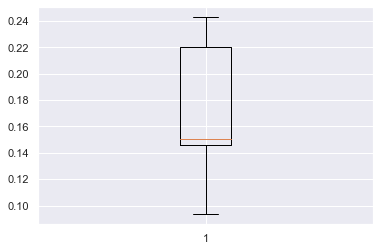

In [754]:
scoring = 'recall'
#Setting number of splits equal to 5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)     
cv_result_bfr = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr);

Metric  Train Accuracy  Test Accuracy  Train Recall  Test Recall  \
Score            0.774          0.774         0.214        0.215   

Metric  Train Precision  Test Precision  Train F1-Score  Test F1-Score  
Score             0.565           0.563           0.310          0.311

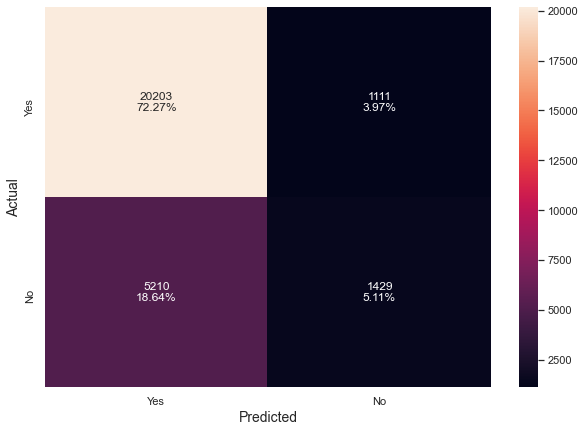

In [755]:
get_metrics_score(lr)
make_confusion_matrix(lr, y_test)

### Oversampling train data

In [756]:
from imblearn.over_sampling import SMOTE

print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))

print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 15490
Before UpSampling, counts of label 'No': 49731 

After UpSampling, counts of label 'Yes': 49731
After UpSampling, counts of label 'No': 49731 

After UpSampling, the shape of train_X: (99462, 33)
After UpSampling, the shape of train_y: (99462,) 



In [757]:
log_reg_over = LogisticRegression(random_state=1)

# Training the basic logistic regression model with the training set 
log_reg_over.fit(X_train_over, y_train_over)

LogisticRegression(random_state=1)

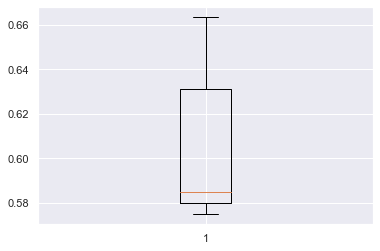

In [758]:
scoring = 'recall'
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)     #Setting number of splits equal to 5
cv_result_over = cross_val_score(estimator=log_reg_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_over);

Metric  Train Accuracy  Test Accuracy  Train Recall  Test Recall  \
Score            0.653          0.653         0.561        0.562   

Metric  Train Precision  Test Precision  Train F1-Score  Test F1-Score  
Score             0.354           0.354           0.434          0.435

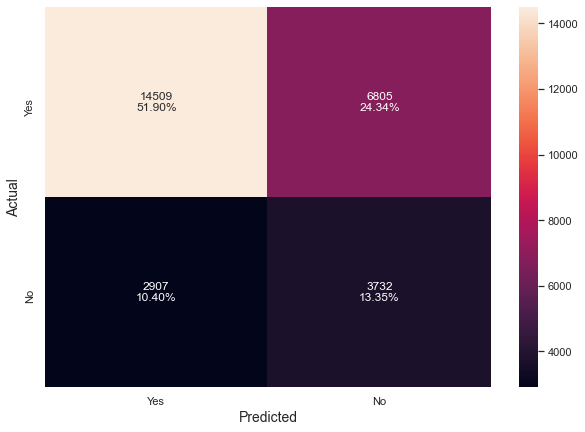

In [759]:
get_metrics_score(log_reg_over)
make_confusion_matrix(log_reg_over, y_test)

### Regularization

In [760]:
# Choose the type of classifier. 
lr_estimator = LogisticRegression(random_state=1)

# Grid of parameters to choose from
parameters = {'C': np.arange(0.1, 1.1, 0.1)}

# Run the grid search
grid_obj = GridSearchCV(lr_estimator, parameters, scoring='recall', n_jobs=-1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
lr_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
lr_estimator.fit(X_train_over, y_train_over)

LogisticRegression(C=0.4, random_state=1)

Metric  Train Accuracy  Test Accuracy  Train Recall  Test Recall  \
Score            0.653          0.653         0.561        0.562   

Metric  Train Precision  Test Precision  Train F1-Score  Test F1-Score  
Score             0.354           0.354           0.434          0.435

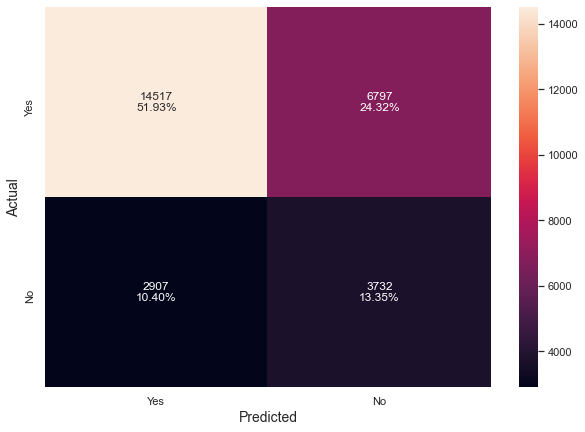

In [761]:
get_metrics_score(lr_estimator)
make_confusion_matrix(lr_estimator, y_test)

In [762]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list

models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree", DecisionTreeClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "BAGGING",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", BaggingClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", RandomForestClassifier(random_state=1)),
            ]
        ),
    )
)

models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost", AdaBoostClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting", GradientBoostingClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost", XGBClassifier(random_state=1, eval_metric='logloss')),
            ]
        ),
    )
)

results = []  # Empty list to store all model's CV scores
names = []   # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold)
    results.append(cv_result)
    names.append(name)

    print(f"{name}: {cv_result.mean() * 100}")

DTREE: 58.56681730148482
BAGGING: 48.84441575209813
RF: 32.027114267269205
ADB: 30.122659780503554
GBM: 32.3692704970949
XGB: 58.99935442220787


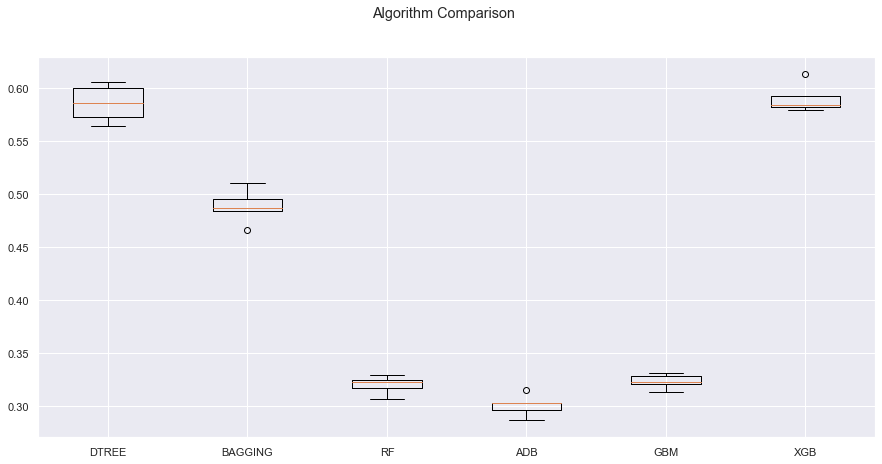

In [763]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names);

<a id=xgbc></a>
## <span style="color:blue">XGBoost Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter Tuning using RandomizedSearchCV

In [764]:
%%time 

#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=1,eval_metric='logloss', n_estimators=50))

#Parameter grid to pass in RandomizedSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),
            'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05],
            'xgbclassifier__gamma':[0,1,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1],
            'xgbclassifier__max_depth':np.arange(1,10,1),
            'xgbclassifier__reg_lambda':[0,1,2,5,10]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, 
                                   scoring=scorer, cv=5, random_state=1, n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print(f"Best Parameters:{randomized_cv.best_params_} \nScore: {randomized_cv.best_score_}")

Best Parameters:{'xgbclassifier__subsample': 1, 'xgbclassifier__scale_pos_weight': 2, 'xgbclassifier__reg_lambda': 2, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0} 
Score: 0.7311696789906184
Wall time: 7min 35s


Metric  Train Accuracy  Test Accuracy  Train Recall  Test Recall  \
Score            0.908          0.881         0.760        0.680   

Metric  Train Precision  Test Precision  Train F1-Score  Test F1-Score  
Score             0.837           0.790           0.796          0.731

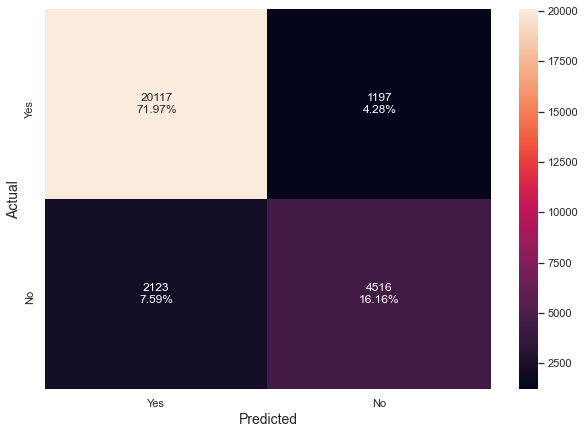

In [730]:
# Creating new pipeline with best parameters
xgb_tuned = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=150,
        scale_pos_weight=2,
        reg_lambda=2,
        max_depth=7,
        subsample=1,
        learning_rate=0.1,
        gamma=0,
        eval_metric='logloss',
        n_jobs=-1
    )
)

# Fit the model on training data
xgb_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(xgb_tuned)

#Creating confusion matrix
make_confusion_matrix(xgb_tuned, y_test)

<a id=bagging></a>
## <span style="color:blue">Bagging Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter tuning using GridSearchCV

In [769]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    'baggingclassifier__max_samples':  [0.7, 0.8, 0.9, 1], 
    'baggingclassifier__max_features': [0.7, 0.8, 0.9, 1],
    'baggingclassifier__n_estimators': [30, 40, 50, 70]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(f"Best Parameters:{grid_cv.best_params_} \nScore: {grid_cv.best_score_}")

Best Parameters:{'baggingclassifier__max_features': 0.9, 'baggingclassifier__max_samples': 0.9, 'baggingclassifier__n_estimators': 50} 
Score: 0.6139120516678518
Wall time: 6min 59s


Metric  Train Accuracy  Test Accuracy  Train Recall  Test Recall  \
Score            0.999          0.857         0.995        0.498   

Metric  Train Precision  Test Precision  Train F1-Score  Test F1-Score  
Score             1.000           0.830           0.997          0.623

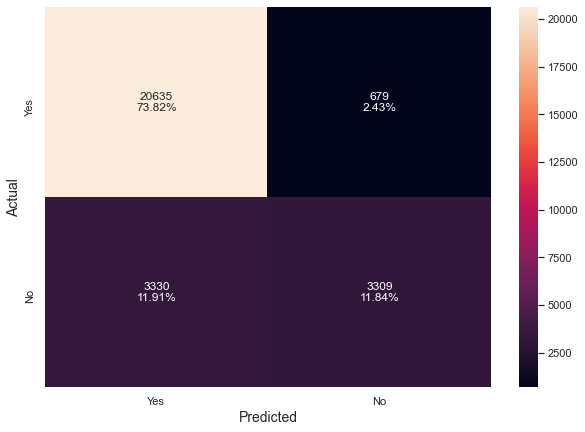

In [770]:
# Creating new pipeline with best parameters
bagg_tuned = make_pipeline(
    StandardScaler(),
    BaggingClassifier(
        max_features=0.9,
        max_samples=0.9,
        random_state=1,
        n_estimators=50,
        n_jobs=-1
    )
)

# Fit the model on training data
bagg_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(bagg_tuned)

#Creating confusion matrix
make_confusion_matrix(bagg_tuned, y_test)

<a id=dtree></a>
## <span style="color:blue">Decision Tree Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter Tuning using GridSearchCV

In [771]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    'decisiontreeclassifier__max_depth': np.arange(2, 30), 
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10],
    'decisiontreeclassifier__max_leaf_nodes' : [2, 3, 5, 10, 15],
    'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(f"Best parameters are {grid_cv.best_params_} \nScore={grid_cv.best_score_}:")

Best parameters are {'decisiontreeclassifier__max_depth': 7, 'decisiontreeclassifier__max_leaf_nodes': 15, 'decisiontreeclassifier__min_impurity_decrease': 0.0001, 'decisiontreeclassifier__min_samples_leaf': 1} with CV score=0.479565520940583:
Wall time: 8min 1s


Metric  Train Accuracy  Test Accuracy  Train Recall  Test Recall  \
Score            0.823          0.819         0.350        0.341   

Metric  Train Precision  Test Precision  Train F1-Score  Test F1-Score  
Score             0.782           0.770           0.484          0.473

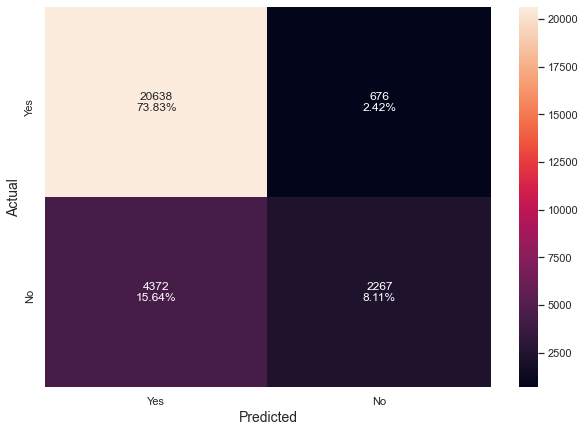

In [774]:
# Creating new pipeline with best parameters
dtree_tuned = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(
        max_depth=7,
        max_leaf_nodes=15,
        random_state=1,
        min_impurity_decrease=0.0001,
        min_samples_leaf=1,
    )
)

# Fit the model on training data
dtree_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(dtree_tuned)

#Creating confusion matrix
make_confusion_matrix(dtree_tuned, y_test)

<a id=stacking></a>
## <span style="color:blue">Stacking Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [ ]:
estimators = [('Bagging Classifier', bagg_tuned), ('Decision Tree', dtree_tuned)]
stacking_classifier= StackingClassifier(estimators=estimators, final_estimator=xgb_tuned)
stacking_classifier.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(stacking_classifier)

#Creating confusion matrix
make_confusion_matrix(stacking_classifier, y_test)

- I will use xgb_tuned model to predict the test set output variables

<a id=testset></a>
## <span style="color:blue">Test Set Prediction</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [783]:
test = pd.read_csv('Test_set.csv')
test.columns

Index(['ID', 'loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit'],
      dtype='object')

In [785]:
test_id = test.ID
test_id.head()

0     4855329
1    66862420
2     3637416
3    53682249
4    53937165
Name: ID, dtype: int64

In [786]:
test.annual_income.fillna(test.annual_income.mean(), inplace=True)
test.last_week_pay.fillna(test.last_week_pay.mean(), inplace=True)
test.total_current_balance.fillna(test.total_current_balance.mean(), inplace=True)
test.total_revolving_limit.fillna(test.total_revolving_limit.mean(), inplace=True)
test.total_acc.fillna(test.total_acc.mean(), inplace=True)

In [787]:
job_experience = {'<5 Years':0, '6-10 years':1, '10+ years':2}
test['job_experience'] = test['job_experience'].map(job_experience).astype('Int32')

loan_term = {'3 years': 0, '5 years': 1}
test['loan_term'] = test['loan_term'].map(loan_term).astype('Int32')

loan_grade = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
test['loan_grade'] = test['loan_grade'].map(loan_grade).astype('Int32')

loan_subgrade = {'A1':0,  'A2':1,  'A3':2,  'A4':3,  'A5':4, 
                 'B1':5,  'B2':6,  'B3':7,  'B4':8,  'B5':9, 
                 'C1':10, 'C2':11, 'C3':12, 'C4':13, 'C5':14,
                 'D1':15, 'D2':16, 'D3':17, 'D4':18, 'D5':19,
                 'E1':20, 'E2':21, 'E3':22, 'E4':23, 'E5':24,
                 'F1':25, 'F2':26, 'F3':27, 'F4':28, 'F5':29,
                 'G1':30, 'G2':31, 'G3':32, 'G4':33, 'G5':34}
test['loan_subgrade'] = test['loan_subgrade'].map(loan_subgrade).astype('Int32')

home_ownership = {'MORTGAGE':0, 'RENT':1, 'OWN':2, 'OTHER':3, 'NONE':4}
test['home_ownership'] = test['home_ownership'].map(home_ownership).astype('Int32')

income_verification_status = {'Verified':0, 'Not Verified':1, 'Source Verified':2}
test['income_verification_status'] = test['income_verification_status'].map(income_verification_status).astype('Int32')

loan_purpose = {'debt_consolidation': 0, 'credit_card':1, 'home_improvement': 2, 'other': 3}
test['loan_purpose'] = test['loan_purpose'].map(loan_purpose).astype('Int32')

application_type = {'INDIVIDUAL': 0, 'JOINT':1}
test['application_type'] = test['application_type'].map(application_type).astype('Int32')

state_code = {'AK':0,  'AL':1,  'AR':2,  'AZ':3,  'CA':4 , 'CO':5,  'CT':6,  'DC':7,  'DE':8, 
              'FL':9,  'GA':10, 'HI':11, 'IA':12, 'ID':13, 'IL':14, 'IN':15, 'KS':16, 'KY':17, 
              'LA':18, 'MA':19, 'MD':20, 'ME':21, 'MI':22, 'MN':23, 'MO':24, 'MS':25, 'MT':26, 
              'NC':27, 'ND':28, 'NE':29, 'NH':30, 'NJ':31, 'NM':32, 'NV':33, 'NY':34, 'OH':35, 
              'OK':36, 'OR':37, 'PA':38, 'RI':39, 'SC':40, 'SD':41, 'TN':42, 'TX':43, 'UT':44, 
              'VA':45, 'VT':46, 'WA':47, 'WI':48, 'WV':49, 'WY':50}
test['state_code'] = test['state_code'].map(state_code).astype('Int32')

In [789]:
imputer = KNNImputer(n_neighbors=5)

In [790]:
try:
    test.drop(['ID'], axis=1, inplace=True)
except:
    print('Already dropped')

Already dropped


In [792]:
print(test.columns)
test.shape

Index(['loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit'],
      dtype='object')


(39933, 21)

In [793]:
test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)
test.head()

loan_amnt  loan_term  interest_rate  loan_grade  loan_subgrade  \
0  12000.000      0.000         15.310       2.000         11.000   
1  12000.000      0.000          7.260       0.000          3.000   
2  15000.000      0.000         14.330       2.000         10.000   
3  12000.000      0.000          9.990       1.000          7.000   
4  20150.000      0.000         11.530       1.000          9.000   

   job_experience  home_ownership  annual_income  income_verification_status  \
0           0.000           0.000      73400.000                       1.000   
1           2.000           0.000     105000.000                       1.000   
2           1.000           0.000      50000.000                       0.000   
3           1.000           1.000      37000.000                       2.000   
4           0.000           1.000      75000.000                       2.000   

   loan_purpose  ...  debt_to_income  delinq_2yrs  public_records  \
0         0.000  ...          14.620        0.000           0.000   
1         1.000  ...          11.380        0.000           0.000   
2         0.000  ...          28.150        0.000           1.000   
3         1.000  ...          34.320        0.000           0.000   
4         0.000  ...          26.740        1.000           0.000   

   revolving_balance  total_acc  interest_receive  application_type  \
0          22156.000     30.000          2290.240             0.000   
1           7592.000     14.000           202.680             0.000   
2          17983.000     19.000          1166.240             0.000   
3          12262.000     18.000           635.060             0.000   
4           8251.000     11.000          1232.840             0.000   

   last_week_pay  total_current_balance  total_revolving_limit  
0         87.000             128098.000              25800.000  
1         13.000             269396.000              23600.000  
2         30.000             220135.000              34100.000  
3         35.000              39436.000              21700.000  
4         31.000              52764.000              12000.000  

[5 rows x 21 columns]

In [794]:
#Checking that no column has missing values in train or test sets
print(test.isna().sum())

loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status    0
loan_purpose                  0
state_code                    0
debt_to_income                0
delinq_2yrs                   0
public_records                0
revolving_balance             0
total_acc                     0
interest_receive              0
application_type              0
last_week_pay                 0
total_current_balance         0
total_revolving_limit         0
dtype: int64


In [796]:
## Function to inverse the encoding
def test_inverse_mapping(x, y):
    inv_dict = {v: k for k, v in x.items()}
    test[y] = np.round(test[y]).map(inv_dict).astype('category')

In [797]:
test_inverse_mapping(job_experience,'job_experience')
test_inverse_mapping(loan_term,'loan_term')
test_inverse_mapping(loan_grade,'loan_grade')
#inverse_mapping(loan_subgrade,'loan_subgrade')
test_inverse_mapping(home_ownership,'home_ownership')
test_inverse_mapping(income_verification_status,'income_verification_status')
test_inverse_mapping(loan_purpose,'loan_purpose')
test_inverse_mapping(application_type,'application_type')
#inverse_mapping(state_code,'state_code')

In [798]:
test.head()

loan_amnt loan_term  interest_rate loan_grade  loan_subgrade  \
0  12000.000   3 years         15.310          C         11.000   
1  12000.000   3 years          7.260          A          3.000   
2  15000.000   3 years         14.330          C         10.000   
3  12000.000   3 years          9.990          B          7.000   
4  20150.000   3 years         11.530          B          9.000   

  job_experience home_ownership  annual_income income_verification_status  \
0       <5 Years       MORTGAGE      73400.000               Not Verified   
1      10+ years       MORTGAGE     105000.000               Not Verified   
2     6-10 years       MORTGAGE      50000.000                   Verified   
3     6-10 years           RENT      37000.000            Source Verified   
4       <5 Years           RENT      75000.000            Source Verified   

         loan_purpose  ...  debt_to_income  delinq_2yrs  public_records  \
0  debt_consolidation  ...          14.620        0.000           0.000   
1         credit_card  ...          11.380        0.000           0.000   
2  debt_consolidation  ...          28.150        0.000           1.000   
3         credit_card  ...          34.320        0.000           0.000   
4  debt_consolidation  ...          26.740        1.000           0.000   

   revolving_balance  total_acc  interest_receive  application_type  \
0          22156.000     30.000          2290.240        INDIVIDUAL   
1           7592.000     14.000           202.680        INDIVIDUAL   
2          17983.000     19.000          1166.240        INDIVIDUAL   
3          12262.000     18.000           635.060        INDIVIDUAL   
4           8251.000     11.000          1232.840        INDIVIDUAL   

  last_week_pay  total_current_balance  total_revolving_limit  
0        87.000             128098.000              25800.000  
1        13.000             269396.000              23600.000  
2        30.000             220135.000              34100.000  
3        35.000              39436.000              21700.000  
4        31.000              52764.000              12000.000  

[5 rows x 21 columns]

In [799]:
cols = test.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(test[i].value_counts(dropna=False))
    print('*'*30)

3 years    28110
5 years    11823
Name: loan_term, dtype: int64
******************************
B    11551
C    10948
A     6764
D     6237
E     3158
F     1030
G      245
Name: loan_grade, dtype: int64
******************************
<5 Years      17866
10+ years     13272
6-10 years     8795
Name: job_experience, dtype: int64
******************************
MORTGAGE    20008
RENT        15938
OWN          3979
OTHER           6
NONE            2
Name: home_ownership, dtype: int64
******************************
Source Verified    14780
Verified           13195
Not Verified       11958
Name: income_verification_status, dtype: int64
******************************
debt_consolidation    23473
credit_card            9383
other                  4693
home_improvement       2384
Name: loan_purpose, dtype: int64
******************************
INDIVIDUAL    39909
JOINT            24
Name: application_type, dtype: int64
******************************


In [800]:
test = pd.get_dummies(test, drop_first=True)
test.shape

(39933, 33)

In [801]:
test.columns

Index(['loan_amnt', 'interest_rate', 'loan_subgrade', 'annual_income',
       'state_code', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'loan_term_5 years',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'job_experience_6-10 years',
       'job_experience_<5 Years', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'income_verification_status_Source Verified',
       'income_verification_status_Verified',
       'loan_purpose_debt_consolidation', 'loan_purpose_home_improvement',
       'loan_purpose_other', 'application_type_JOINT'],
      dtype='object')

In [803]:
pred = xgb_tuned.predict(test)
print(f"Prediction has length: {len(pred)}")

Prediction has length: 39933


In [808]:
prediction_dict = {
    'ID': test_id,
    'default': pred
}
submit_df = pd.DataFrame(prediction_dict)
submit_df.head()

ID  default
0   4855329        1
1  66862420        0
2   3637416        1
3  53682249        0
4  53937165        0

In [811]:
submit_df.to_csv('Cardinal_submission.csv', index=False)